# Project overview
In 2017, Instacart published a dataset with over 3 million grocery orders placed on their platform. For my 3rd capstone, I'll collect information about unique customers from the published information, then apply unsupervised learning to make recommendations about customer segmentation for targeted marketing.

More information about the dataset is available at: https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2.

*Data Citation:*
"The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 1/30/2020

# Setting up environment

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter, defaultdict
from sklearn import metrics

# Importing data

In [3]:
orders_df = pd.read_csv('/Users/ellenpaigehoffman/Desktop/Thinkful/instacart_May 2017/orders.csv')

In [4]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
orders_df.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [6]:
# I will use data from the prior set in my analysis and model
orders_df = orders_df[orders_df['eval_set'] == 'prior']
orders_df = orders_df.reset_index()

In [7]:
print('Shape of the orders dataset: {}'.format(orders_df.shape))

Shape of the orders dataset: (3214874, 8)


In [8]:
products_df = pd.read_csv('/Users/ellenpaigehoffman/Desktop/Thinkful/instacart_May 2017/products.csv')

In [9]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [10]:
print('Shape of the products dataset: {}'.format(products_df.shape))

Shape of the products dataset: (49688, 4)


In [11]:
carts_df = pd.read_csv('/Users/ellenpaigehoffman/Desktop/Thinkful/instacart_May 2017/order_products__prior.csv')

In [12]:
carts_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
print('Shape of the orders dataset: {}'.format(carts_df.shape))

Shape of the orders dataset: (32434489, 4)


In [14]:
depts_df = pd.read_csv('/Users/ellenpaigehoffman/Desktop/Thinkful/instacart_May 2017/departments.csv')

In [15]:
depts_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [16]:
print('Shape of the departments dataset: {}'.format(depts_df.shape))

Shape of the departments dataset: (21, 2)


# Exploratory data analysis

In [17]:
# defining plotting function for EDA

def plot_distribution(df, var):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,4))
    plt.suptitle(var)
    
    plt.subplot(1,2,1)
    plt.hist(df[var])
    
    plt.subplot (1,2,2)
    plt.boxplot(df.dropna(subset=[var])[var]);    

## Orders

In [18]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214874 entries, 0 to 3214873
Data columns (total 8 columns):
index                     int64
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(6), object(1)
memory usage: 196.2+ MB


In [19]:
orders_df.describe().round(2)

,index,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3214874.00,3214874.00,3214874.00,3214874.00,3214874.00,3214874.00,3008665.00
mean,1710405.58,1710826.93,102970.08,17.19,2.78,13.44,10.71
std,987588.16,987520.61,59534.11,17.80,2.04,4.23,8.95
min,0.00,2.00,1.00,1.00,0.00,0.00,0.00
25%,855102.25,855683.25,51385.00,5.00,1.00,10.00,4.00
50%,1710097.50,1711120.50,102662.00,11.00,3.00,13.00,7.00
75%,2565525.75,2566033.75,154372.00,24.00,5.00,16.00,15.00
max,3421081.00,3421083.00,206209.00,99.00,6.00,23.00,30.00


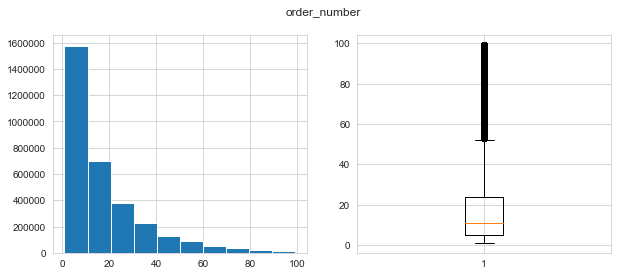

In [21]:
plot_distribution(orders_df, 'order_number')

In [20]:
# checking range of orders per customer
orders_df.groupby('user_id')['order_number'].count().sort_values()

user_id
127633     3
74147      3
160570     3
160560     3
74171      3
          ..
1868      99
31118     99
122476    99
120897    99
26086     99
Name: order_number, Length: 206209, dtype: int64

In [22]:
print('Average orders per customer: {}'.format(orders_df.groupby('user_id')['order_id'].count().mean()))

Average orders per customer: 15.590367054784224


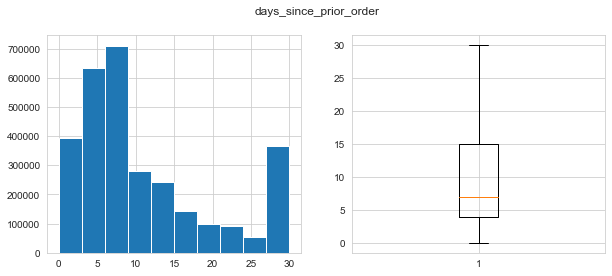

In [23]:
plot_distribution(orders_df, 'days_since_prior_order')

In [24]:
orders_df.days_since_prior_order.value_counts().sort_values(ascending=False)

7.0     306181
30.0    306137
6.0     230245
4.0     214488
3.0     210665
5.0     206691
2.0     187723
8.0     173259
1.0     141011
9.0     112184
14.0     93064
10.0     90198
13.0     77765
11.0     76394
12.0     71356
0.0      64436
15.0     61883
16.0     43423
21.0     41262
17.0     36281
20.0     35173
18.0     33050
19.0     31408
22.0     29125
28.0     23833
23.0     21629
27.0     19677
24.0     18704
25.0     17324
26.0     17120
29.0     16976
Name: days_since_prior_order, dtype: int64

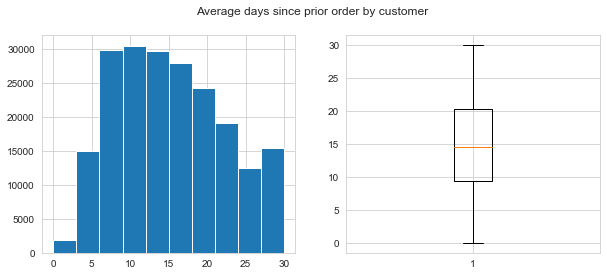

In [25]:
plt.figure(figsize=(10,4))
plt.suptitle('Average days since prior order by customer')

plt.subplot(1,2,1)
plt.hist(orders_df.groupby('user_id')['days_since_prior_order'].mean())

plt.subplot(1,2,2)
plt.boxplot(orders_df.groupby('user_id')['days_since_prior_order'].mean());

In [26]:
print('Average of average days since prior order by customer: {}'.format(orders_df.groupby('user_id')['days_since_prior_order'].mean().mean()))

Average of average days since prior order by customer: 15.209435406812005


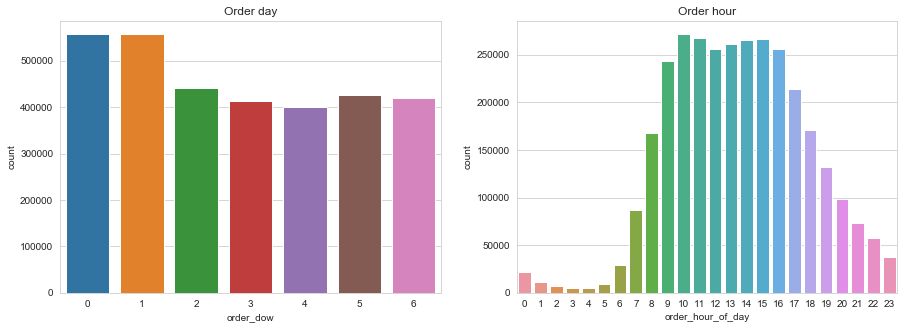

In [27]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot(x='order_dow', data=orders_df)
plt.title('Order day')

plt.subplot(1,2,2)
sns.countplot(x='order_hour_of_day', data=orders_df)
plt.title('Order hour');

In [28]:
orders_df.order_dow.value_counts()

0    557772
1    556705
2    441955
5    425982
6    418848
3    412400
4    401212
Name: order_dow, dtype: int64

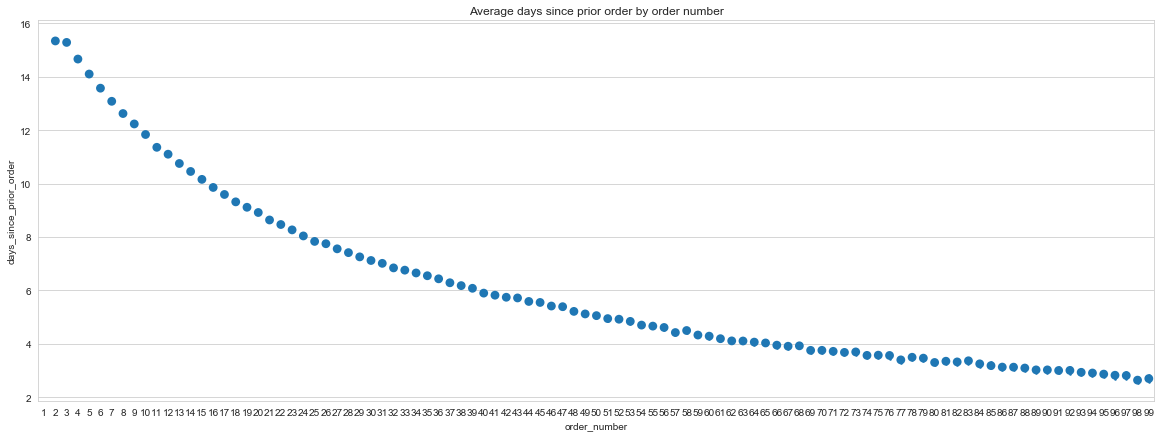

In [29]:
plt.figure(figsize=(20,7))
sns.pointplot(x= 'order_number', y='days_since_prior_order', data=orders_df, join=False)
plt.title('Average days since prior order by order number');

In [30]:
pearsonr(orders_df.dropna(subset=['days_since_prior_order']).order_number, 
         orders_df.dropna(subset=['days_since_prior_order']).days_since_prior_order)

(-0.36044622929747133, 0.0)

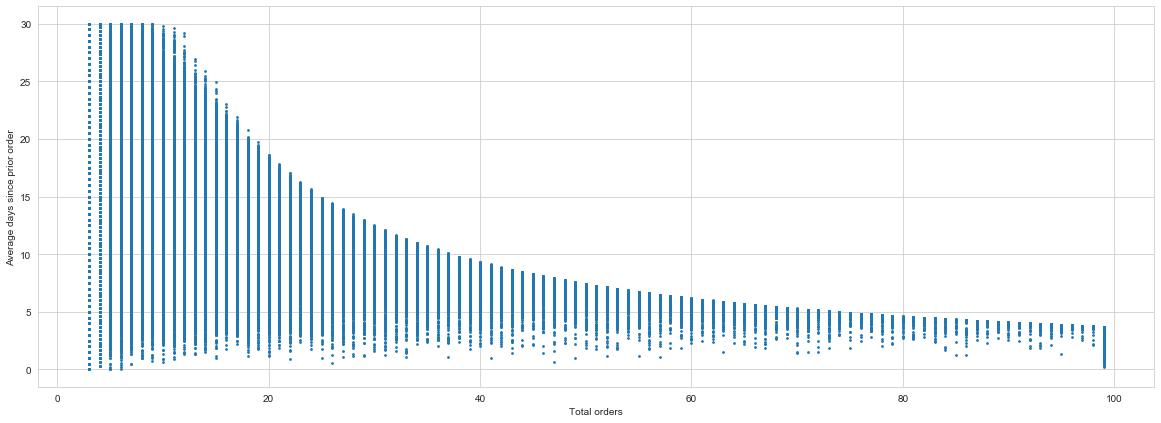

In [31]:
plt.figure(figsize=(20,7))
plt.scatter(orders_df.groupby('user_id')['order_id'].count(), 
            orders_df.groupby('user_id')['days_since_prior_order'].mean(),
            s=3)
plt.ylabel('Average days since prior order')
plt.xlabel('Total orders');

In [32]:
pearsonr(orders_df.groupby('user_id')['order_id'].count(), orders_df.groupby('user_id')['days_since_prior_order'].mean())

(-0.55510190831309, 0.0)

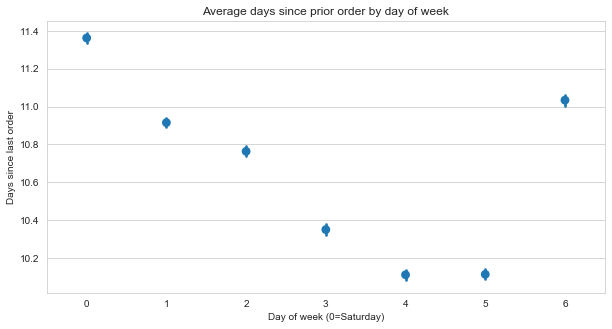

In [38]:
plt.figure(figsize=(10,5))
sns.pointplot(x= 'order_dow', y='days_since_prior_order', data=orders_df, join=False)
plt.title('Average days since prior order by day of week')
plt.xlabel('Day of week (0=Saturday)')
plt.ylabel('Days since last order');

**Observations:**
- Order numbers range from 1-99. There are 3-99 orders per customer. As expected, distribution of both variables skew right. On average, each customer places about 16 orders. 
- Days since prior order ranges from 0-30 and averages at about 11 days. The distribution increases from 0-7 days, then decreases until there is a spike at 30+ days. *The documentation states this variable was capped at 30.*
- There are more orders on weekends than any of the weekdays. About 35% of all orders were placed on Saturday or Sunday.
- The majority of orders are placed between 9am-4pm, with most at 10am.
- As total orders per customers increases, their average days since prior order decreases. 
- Average days since prior order is highest on Sunday and decreases slightly throughout the week, by about a day in total.

## Products

In [34]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [35]:
products_df.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


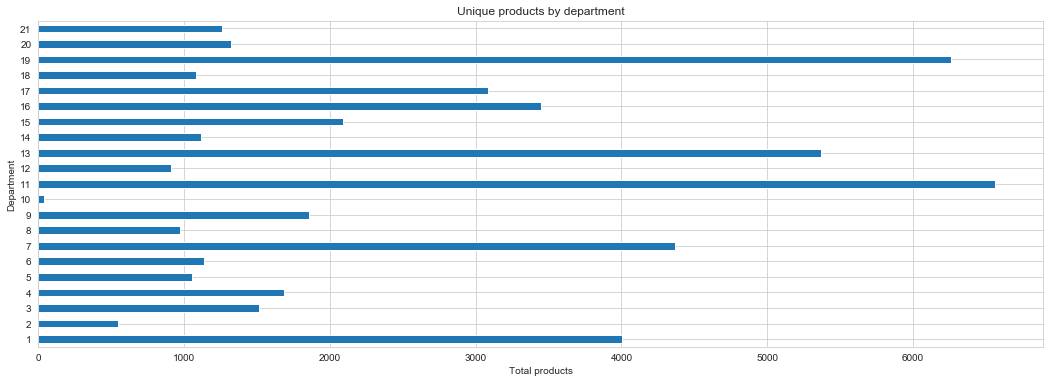

In [36]:
plt.figure(figsize=(18,6))
products_df.groupby('department_id')['product_id'].count().plot('barh')
plt.title('Unique products by department')
plt.xlabel('Total products')
plt.ylabel('Department');

In [37]:
print('Average products per department: {}'.format(products_df.groupby('department_id')['product_id'].count().mean()))

Average products per department: 2366.095238095238


**Observations:**
- There are 21 department and 134 aisle categories.
- The personal care (11) and babies (19) departments have the most unique products, each over 6,000. The bulk department (10) has the least.
- On average, departments have about 2,366 unique products, but there is a lot of variability.

## Carts

In [39]:
carts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [40]:
carts_df.describe().round(2)

,order_id,product_id,add_to_cart_order,reordered
count,32434489.00,32434489.00,32434489.00,32434489.00
mean,1710748.52,25576.34,8.35,0.59
std,987300.70,14096.69,7.13,0.49
min,2.00,1.00,1.00,0.00
25%,855943.00,13530.00,3.00,0.00
50%,1711048.00,25256.00,6.00,1.00
75%,2565514.00,37935.00,11.00,1.00
max,3421083.00,49688.00,145.00,1.00


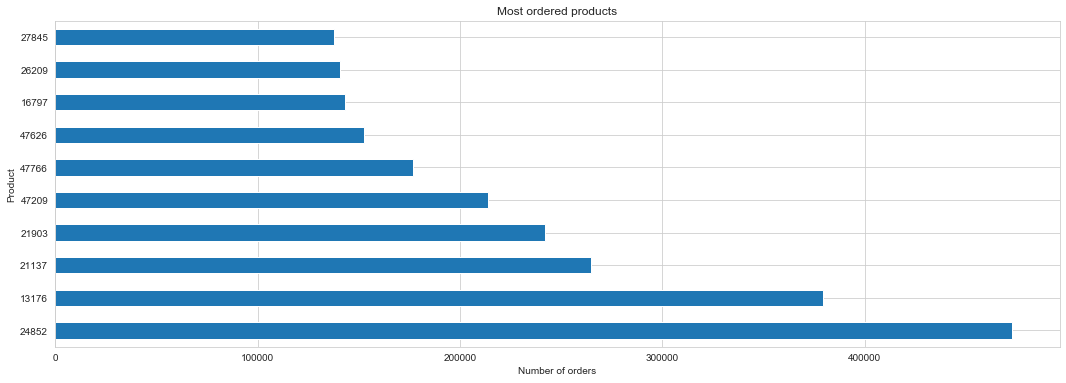

In [41]:
plt.figure(figsize=(18,6))
carts_df.product_id.value_counts().sort_values(ascending=False).head(10).plot('barh')
plt.title('Most ordered products')
plt.xlabel('Number of orders')
plt.ylabel('Product');

In [42]:
products_df[products_df['product_id'].isin([24852, 13176, 21137, 21903, 47209,
                                           47766, 47626, 16797, 26209, 27845])]

,product_id,product_name,aisle_id,department_id
13175,13176,Bag of Organic Bananas,24,4
16796,16797,Strawberries,24,4
21136,21137,Organic Strawberries,24,4
21902,21903,Organic Baby Spinach,123,4
24851,24852,Banana,24,4
26208,26209,Limes,24,4
27844,27845,Organic Whole Milk,84,16
47208,47209,Organic Hass Avocado,24,4
47625,47626,Large Lemon,24,4
47765,47766,Organic Avocado,24,4


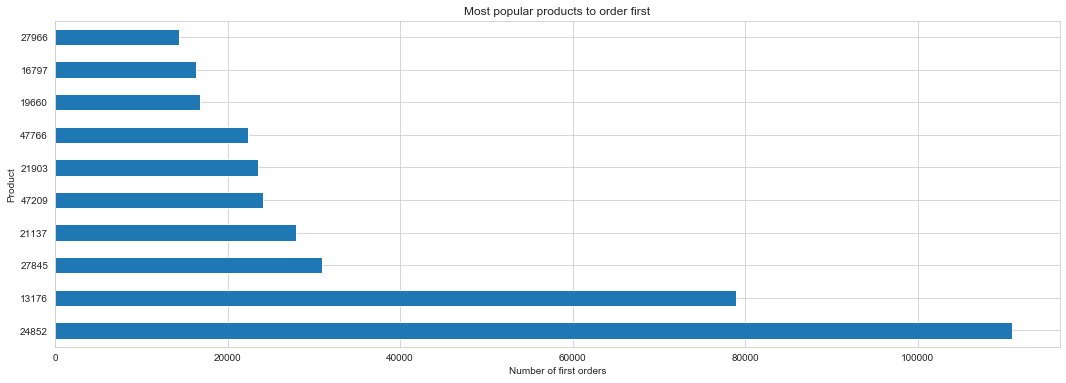

In [43]:
plt.figure(figsize=(18,6))
carts_df[carts_df['add_to_cart_order']==1].product_id.value_counts().sort_values(ascending=False).head(10).plot('barh')
plt.title('Most popular products to order first')
plt.xlabel('Number of first orders')
plt.ylabel('Product');

In [44]:
products_df[products_df['product_id'].isin([24852, 13176, 27845, 21137, 47209,
                                           21903, 47766, 19660, 16797, 27966])]

,product_id,product_name,aisle_id,department_id
13175,13176,Bag of Organic Bananas,24,4
16796,16797,Strawberries,24,4
19659,19660,Spring Water,115,7
21136,21137,Organic Strawberries,24,4
21902,21903,Organic Baby Spinach,123,4
24851,24852,Banana,24,4
27844,27845,Organic Whole Milk,84,16
27965,27966,Organic Raspberries,123,4
47208,47209,Organic Hass Avocado,24,4
47765,47766,Organic Avocado,24,4


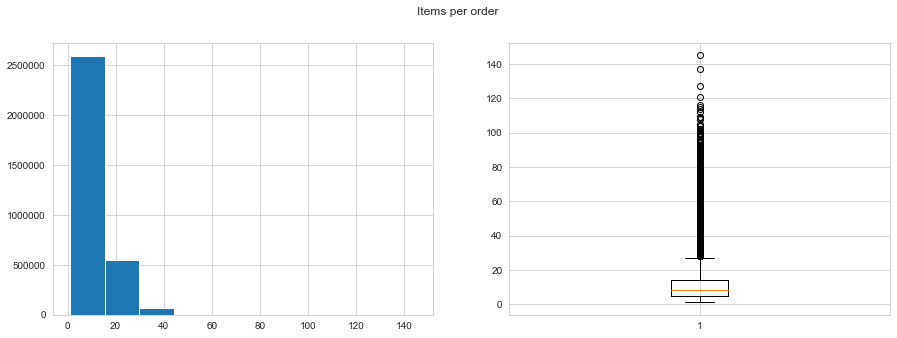

In [45]:
plt.figure(figsize=(15,5))
plt.suptitle('Items per order')

plt.subplot(1,2,1)
plt.hist(carts_df.groupby('order_id')['product_id'].count())

plt.subplot(1,2,2)
plt.boxplot(carts_df.groupby('order_id')['product_id'].count());

In [46]:
print('Average items per order: {}'.format(carts_df.groupby('order_id')['product_id'].count().mean()))

Average items per order: 10.088883421247614


In [47]:
print('Minimum items per order: {}'.format(carts_df.groupby('order_id')['product_id'].count().min()))

Minimum items per order: 1


In [48]:
print('Maximum items per order: {}'.format(carts_df.groupby('order_id')['product_id'].count().max()))

Maximum items per order: 145


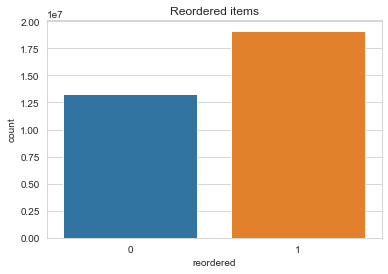

In [49]:
sns.countplot(x='reordered', data=carts_df)
plt.title('Reordered items');

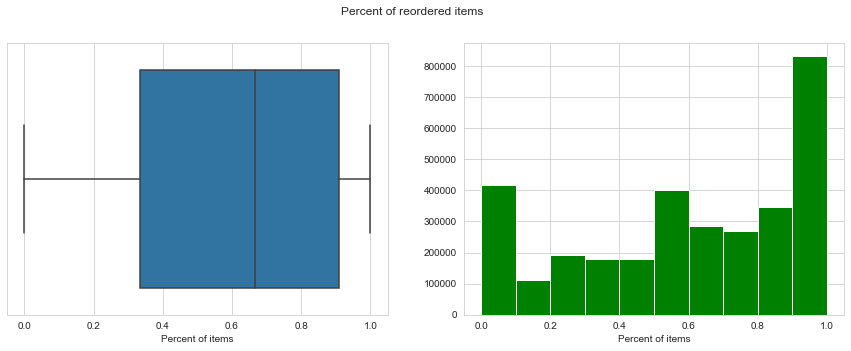

In [50]:
plt.figure(figsize=(15,5))
plt.suptitle('Percent of reordered items')

plt.subplot(1,2,1)
sns.boxplot(carts_df.groupby('order_id')['reordered'].sum() / carts_df.groupby('order_id')['product_id'].count())
plt.xlabel('Percent of items')

plt.subplot(1,2,2)
plt.hist(carts_df.groupby('order_id')['reordered'].sum() / carts_df.groupby('order_id')['product_id'].count(), 
         color='g')
plt.xlabel('Percent of items');

In [51]:
print('Average % of reordered items: {}%'.format(round((carts_df.groupby('order_id')['reordered'].sum() / carts_df.groupby('order_id')['product_id'].count()).mean()*100)))

Average % of reordered items: 60%


**Observations:**
- Conventional banana, followed by a bag of organic bananas are the most popular items. Bananas are also ordered first more frequently than other products.
- Nine of the ten most popular items are from the produce department, and many are organic. The most popular non-produce item is organic whole milk.
- The average order has 10 items. Orders in the dataset range from 1 to 145 items. The distribution for items per order skews right, with upper outliers.
- There are more reorders in the dataset than first-time purchases. On average, 60% of items per order are reorders.

# Feature engineering and exploration

## Creating a customer dataframe

In [52]:
# creating df with user_id and total orders per customer
customer_df = orders_df.groupby('user_id')['order_id'].count().reset_index()
customer_df.columns = ['user_id','total_orders']

In [53]:
# average days since prior order
avg_days_since_prior = orders_df.groupby('user_id')['days_since_prior_order'].mean().reset_index()
avg_days_since_prior.columns = ['user_id','avg_days_since_prior']

# merging dfs
customer_df = pd.merge(customer_df, avg_days_since_prior, how='outer')

In [54]:
# minimum days since prior order
min_days_since_prior = orders_df.groupby('user_id')['days_since_prior_order'].min().reset_index()
min_days_since_prior.columns = ['user_id','min_days_since_prior']

customer_df = pd.merge(customer_df, min_days_since_prior, how='outer')

In [55]:
# maximum days since prior order
max_days_since_prior = orders_df.groupby('user_id')['days_since_prior_order'].max().reset_index()
max_days_since_prior.columns = ['user_id','max_days_since_prior']

customer_df = pd.merge(customer_df, max_days_since_prior, how='outer')

In [56]:
# weekend orders
weekend_orders = orders_df[orders_df.order_dow.isin([0,1])].groupby('user_id')['order_id'].count().reset_index()
weekend_orders.columns = ['user_id','weekend_orders']

customer_df = pd.merge(customer_df, weekend_orders, how='outer')

# filling rows with no weekend orders with 0
customer_df['weekend_orders'].fillna(0, inplace = True) 

In [57]:
# offpeak orders
offpeak_orders = orders_df[orders_df.order_hour_of_day.isin([0,1,2,3,4,5,6,7,8,17,18,19,20,
                                                            21,22,23])].groupby('user_id')['order_id'].count().reset_index()
offpeak_orders.columns = ['user_id','offpeak_orders']

customer_df = pd.merge(customer_df, offpeak_orders, how='outer')

# filling rows with no offpeak orders with 0
customer_df['offpeak_orders'].fillna(0, inplace = True)

In [58]:
# afternoon peak orders
pm_peak_orders = orders_df[orders_df.order_hour_of_day.isin([13,14,15,16])].groupby('user_id')['order_id'].count().reset_index()
pm_peak_orders.columns = ['user_id','pm_peak_orders']

customer_df = pd.merge(customer_df, pm_peak_orders, how='outer')

# filling nulls
customer_df['pm_peak_orders'].fillna(0, inplace=True)

In [59]:
# creating variables, percent of total orders
customer_df['pct_weekend'] = customer_df['weekend_orders'] / customer_df['total_orders']
customer_df['pct_offpeak'] = customer_df['offpeak_orders'] / customer_df['total_orders']
customer_df['pct_pm_peak'] = customer_df['pm_peak_orders'] / customer_df['total_orders']

In [60]:
customer_df.head()

,user_id,total_orders,avg_days_since_prior,min_days_since_prior,max_days_since_prior,weekend_orders,offpeak_orders,pm_peak_orders,pct_weekend,pct_offpeak,pct_pm_peak
0,1,10,19.555556,0.0,30.0,3.0,5.0,3.0,0.300000,0.500000,0.300000
1,2,14,15.230769,3.0,30.0,5.0,0.0,1.0,0.357143,0.000000,0.071429
2,3,12,12.090909,7.0,21.0,8.0,5.0,7.0,0.666667,0.416667,0.583333
3,4,5,13.750000,0.0,21.0,0.0,0.0,3.0,0.000000,0.000000,0.600000
4,5,4,13.333333,10.0,19.0,2.0,2.0,1.0,0.500000,0.500000,0.250000


In [61]:
# adding user_id to transactions dataset
carts_df = carts_df.merge(orders_df[['order_id','user_id']], on='order_id')

In [62]:
# total products ordered
total_products = carts_df.groupby('user_id')['product_id'].count().reset_index()
total_products.columns = ['user_id', 'total_products']

customer_df = pd.merge(customer_df, total_products, how='outer')

In [63]:
# average number of items per order
avg_products_per_order = carts_df.groupby(['user_id', 'order_id'])['product_id'].count().groupby('user_id').mean().reset_index()
avg_products_per_order.columns = ['user_id', 'avg_products_per_order']

customer_df = pd.merge(customer_df, avg_products_per_order, how='outer')

In [64]:
# total reordered items
total_reordered = carts_df.groupby('user_id')['reordered'].sum().reset_index()
total_reordered.columns = ['user_id', 'total_reordered']

customer_df = pd.merge(customer_df, total_reordered, how='outer')

In [65]:
# average number of reordered items per order
avg_reordered_per_order = carts_df.groupby(['user_id', 'order_id'])['reordered'].sum().groupby('user_id').mean().reset_index()
avg_reordered_per_order.columns = ['user_id', 'avg_reordered_per_order']

customer_df = pd.merge(customer_df, avg_reordered_per_order, how='outer')

In [66]:
# creating variable, percent of reordered products
customer_df['pct_reordered'] = customer_df['total_reordered'] / customer_df['total_products']

In [67]:
customer_df.head()

,user_id,total_orders,avg_days_since_prior,min_days_since_prior,max_days_since_prior,weekend_orders,offpeak_orders,pm_peak_orders,pct_weekend,pct_offpeak,pct_pm_peak,total_products,avg_products_per_order,total_reordered,avg_reordered_per_order,pct_reordered
0,1,10,19.555556,0.0,30.0,3.0,5.0,3.0,0.300000,0.500000,0.300000,59,5.900000,41,4.100000,0.694915
1,2,14,15.230769,3.0,30.0,5.0,0.0,1.0,0.357143,0.000000,0.071429,195,13.928571,93,6.642857,0.476923
2,3,12,12.090909,7.0,21.0,8.0,5.0,7.0,0.666667,0.416667,0.583333,88,7.333333,55,4.583333,0.625000
3,4,5,13.750000,0.0,21.0,0.0,0.0,3.0,0.000000,0.000000,0.600000,18,3.600000,1,0.200000,0.055556
4,5,4,13.333333,10.0,19.0,2.0,2.0,1.0,0.500000,0.500000,0.250000,37,9.250000,14,3.500000,0.378378


In [68]:
# adding departments to transactions dataset
carts_df = pd.merge(carts_df, products_df[['product_id','department_id']])

In [69]:
carts_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,department_id
0,2,33120,1,1,202279,16
1,26,33120,5,0,153404,16
2,120,33120,13,0,23750,16
3,327,33120,5,1,58707,16
4,390,33120,28,1,166654,16


In [70]:
# total frozen dept items
total_frozen = carts_df[carts_df['department_id']==1].groupby('user_id')['product_id'].count().reset_index()
total_frozen.columns = ['user_id', 'total_frozen']

# merging dataframes
customer_df = pd.merge(customer_df, total_frozen, how='outer')

# filling rows with no frozen items with 0
customer_df['total_frozen'].fillna(0, inplace=True)

In [71]:
# total other dept items
total_other = carts_df[carts_df['department_id']==2].groupby('user_id')['product_id'].count().reset_index()
total_other.columns = ['user_id', 'total_other']

customer_df = pd.merge(customer_df, total_other, how='outer')

customer_df['total_other'].fillna(0, inplace=True)

In [72]:
# total bakery dept items
total_bakery = carts_df[carts_df['department_id']==3].groupby('user_id')['product_id'].count().reset_index()
total_bakery.columns = ['user_id', 'total_bakery']

customer_df = pd.merge(customer_df, total_bakery, how='outer')

customer_df['total_bakery'].fillna(0, inplace=True)

In [73]:
# total produce dept items
total_produce = carts_df[carts_df['department_id']==4].groupby('user_id')['product_id'].count().reset_index()
total_produce.columns = ['user_id', 'total_produce']
customer_df = pd.merge(customer_df, total_produce, how='outer')
customer_df['total_produce'].fillna(0, inplace=True)

In [74]:
# total alcohol dept items
total_alcohol = carts_df[carts_df['department_id']==5].groupby('user_id')['product_id'].count().reset_index()
total_alcohol.columns = ['user_id', 'total_alcohol']
customer_df = pd.merge(customer_df, total_alcohol, how='outer')
customer_df['total_alcohol'].fillna(0, inplace=True)

In [75]:
# total international dept items
total_inter = carts_df[carts_df['department_id']==6].groupby('user_id')['product_id'].count().reset_index()
total_inter.columns = ['user_id', 'total_inter']
customer_df = pd.merge(customer_df, total_inter, how='outer')
customer_df['total_inter'].fillna(0, inplace=True)

In [76]:
# total beverages dept items
total_bevs = carts_df[carts_df['department_id']==7].groupby('user_id')['product_id'].count().reset_index()
total_bevs.columns = ['user_id', 'total_bevs']
customer_df = pd.merge(customer_df, total_bevs, how='outer')
customer_df['total_bevs'].fillna(0, inplace=True)

In [77]:
# total pets dept items
total_pets = carts_df[carts_df['department_id']==8].groupby('user_id')['product_id'].count().reset_index()
total_pets.columns = ['user_id', 'total_pets']
customer_df = pd.merge(customer_df, total_pets, how='outer')
customer_df['total_pets'].fillna(0, inplace=True)

In [78]:
# total dry goods pasta dept items
total_pasta = carts_df[carts_df['department_id']==9].groupby('user_id')['product_id'].count().reset_index()
total_pasta.columns = ['user_id', 'total_pasta']
customer_df = pd.merge(customer_df, total_pasta, how='outer')
customer_df['total_pasta'].fillna(0, inplace=True)

In [79]:
# total bulk dept items
total_bulk = carts_df[carts_df['department_id']==10].groupby('user_id')['product_id'].count().reset_index()
total_bulk.columns = ['user_id', 'total_bulk']
customer_df = pd.merge(customer_df, total_bulk, how='outer')
customer_df['total_bulk'].fillna(0, inplace=True)

In [80]:
# total personal care dept items
total_personal = carts_df[carts_df['department_id']==11].groupby('user_id')['product_id'].count().reset_index()
total_personal.columns = ['user_id', 'total_personal']
customer_df = pd.merge(customer_df, total_personal, how='outer')
customer_df['total_personal'].fillna(0, inplace=True)

In [81]:
# total meat-seafood dept items
total_meatsea = carts_df[carts_df['department_id']==12].groupby('user_id')['product_id'].count().reset_index()
total_meatsea.columns = ['user_id', 'total_meatsea']
customer_df = pd.merge(customer_df, total_meatsea, how='outer')
customer_df['total_meatsea'].fillna(0, inplace=True)

In [82]:
# total pantry dept items
total_pantry = carts_df[carts_df['department_id']==13].groupby('user_id')['product_id'].count().reset_index()
total_pantry.columns = ['user_id', 'total_pantry']
customer_df = pd.merge(customer_df, total_pantry, how='outer')
customer_df['total_pantry'].fillna(0, inplace=True)

In [83]:
# total breakfast dept items
total_bfast = carts_df[carts_df['department_id']==14].groupby('user_id')['product_id'].count().reset_index()
total_bfast.columns = ['user_id', 'total_bfast']
customer_df = pd.merge(customer_df, total_bfast, how='outer')
customer_df['total_bfast'].fillna(0, inplace=True)

In [84]:
# total canned goods dept items
total_cans = carts_df[carts_df['department_id']==15].groupby('user_id')['product_id'].count().reset_index()
total_cans.columns = ['user_id', 'total_cans']
customer_df = pd.merge(customer_df, total_cans, how='outer')
customer_df['total_cans'].fillna(0, inplace=True)

In [85]:
# total dairy-eggs dept items
total_dairy = carts_df[carts_df['department_id']==16].groupby('user_id')['product_id'].count().reset_index()
total_dairy.columns = ['user_id', 'total_dairy']
customer_df = pd.merge(customer_df, total_dairy, how='outer')
customer_df['total_dairy'].fillna(0, inplace=True)

In [86]:
# total household dept items
total_house = carts_df[carts_df['department_id']==17].groupby('user_id')['product_id'].count().reset_index()
total_house.columns = ['user_id', 'total_house']
customer_df = pd.merge(customer_df, total_house, how='outer')
customer_df['total_house'].fillna(0, inplace=True)

In [87]:
# total babies dept items
total_babies = carts_df[carts_df['department_id']==18].groupby('user_id')['product_id'].count().reset_index()
total_babies.columns = ['user_id', 'total_babies']
customer_df = pd.merge(customer_df, total_babies, how='outer')
customer_df['total_babies'].fillna(0, inplace=True)

In [88]:
# total snacks dept items
total_snacks = carts_df[carts_df['department_id']==19].groupby('user_id')['product_id'].count().reset_index()
total_snacks.columns = ['user_id', 'total_snacks']
customer_df = pd.merge(customer_df, total_snacks, how='outer')
customer_df['total_snacks'].fillna(0, inplace=True)

In [89]:
# total deli dept items
total_deli = carts_df[carts_df['department_id']==20].groupby('user_id')['product_id'].count().reset_index()
total_deli.columns = ['user_id', 'total_deli']
customer_df = pd.merge(customer_df, total_deli, how='outer')
customer_df['total_deli'].fillna(0, inplace=True)

In [90]:
# creating variable, pct of total products by department
total_depts = ['total_frozen', 'total_other', 'total_bakery', 'total_produce',
               'total_alcohol', 'total_inter', 'total_bevs', 'total_pets',
               'total_pasta', 'total_bulk', 'total_personal', 'total_meatsea',
               'total_pantry', 'total_bfast', 'total_cans', 'total_dairy',
               'total_house', 'total_babies', 'total_snacks', 'total_deli']

for x in total_depts:
    customer_df['pct_'+ x] = customer_df[x] / customer_df['total_products']

In [91]:
customer_df.head()

,user_id,total_orders,avg_days_since_prior,min_days_since_prior,max_days_since_prior,weekend_orders,offpeak_orders,pm_peak_orders,pct_weekend,pct_offpeak,...,pct_total_personal,pct_total_meatsea,pct_total_pantry,pct_total_bfast,pct_total_cans,pct_total_dairy,pct_total_house,pct_total_babies,pct_total_snacks,pct_total_deli
0,1,10,19.555556,0.0,30.0,3.0,5.0,3.0,0.300000,0.500000,...,0.000000,0.000000,0.016949,0.050847,0.000000,0.220339,0.033898,0.0,0.372881,0.000000
1,2,14,15.230769,3.0,30.0,5.0,0.0,1.0,0.357143,0.000000,...,0.005128,0.005128,0.056410,0.015385,0.005128,0.246154,0.000000,0.0,0.215385,0.107692
2,3,12,12.090909,7.0,21.0,8.0,5.0,7.0,0.666667,0.416667,...,0.000000,0.000000,0.045455,0.000000,0.000000,0.238636,0.011364,0.0,0.102273,0.022727
3,4,5,13.750000,0.0,21.0,0.0,0.0,3.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.111111,0.0,0.055556,0.111111
4,5,4,13.333333,10.0,19.0,2.0,2.0,1.0,0.500000,0.500000,...,0.000000,0.000000,0.054054,0.000000,0.027027,0.216216,0.000000,0.0,0.027027,0.027027


In [92]:
customer_df.shape

(206209, 56)

## Exploring features

In [93]:
features_df = customer_df[['user_id', 'total_orders', 'avg_days_since_prior', 
                           'min_days_since_prior', 'max_days_since_prior', 
                           'pct_weekend', 'pct_offpeak', 'pct_pm_peak',
                           'total_products', 'avg_products_per_order',
                           'pct_reordered', 'pct_total_frozen', 'pct_total_other',
                           'pct_total_bakery', 'pct_total_produce', 'pct_total_alcohol',
                           'pct_total_inter', 'pct_total_bevs', 'pct_total_pets',
                           'pct_total_pasta', 'pct_total_bulk', 'pct_total_personal',
                           'pct_total_meatsea', 'pct_total_pantry', 'pct_total_bfast',
                           'pct_total_cans', 'pct_total_dairy', 'pct_total_house',
                           'pct_total_babies', 'pct_total_snacks', 'pct_total_deli']]

In [94]:
features_df.shape

(206209, 31)

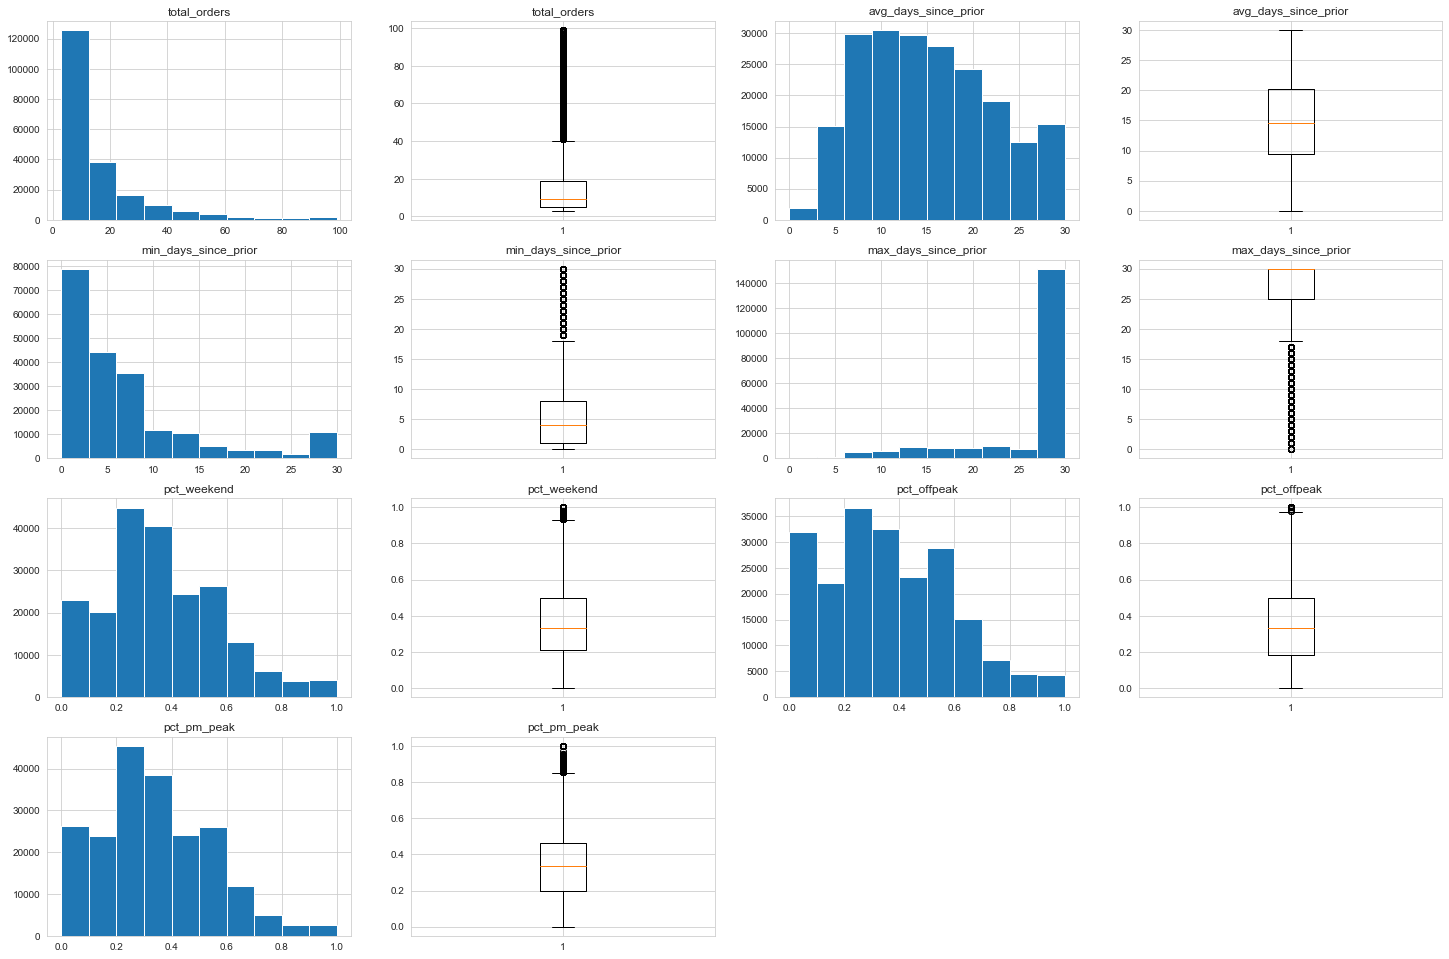

In [95]:
# orders and order time
orders = ['total_orders', 'avg_days_since_prior','min_days_since_prior',
          'max_days_since_prior','pct_weekend', 'pct_offpeak', 'pct_pm_peak']

x=0
plt.figure(figsize=(25,30))
for col in orders:
    plt.subplot(7,4,x+1)
    plt.hist(features_df[col])
    plt.title(col)
    plt.subplot(7,4,x+2)
    plt.boxplot(features_df[col])
    plt.title(col)
    x=x+2

In [96]:
features_df[orders].describe().round(2)

,total_orders,avg_days_since_prior,min_days_since_prior,max_days_since_prior,pct_weekend,pct_offpeak,pct_pm_peak
count,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00
mean,15.59,15.21,6.47,26.30,0.35,0.35,0.33
std,16.65,7.11,7.58,6.65,0.22,0.24,0.21
min,3.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.00,9.42,1.00,25.00,0.21,0.18,0.20
50%,9.00,14.50,4.00,30.00,0.33,0.33,0.33
75%,19.00,20.29,8.00,30.00,0.50,0.50,0.46
max,99.00,30.00,30.00,30.00,1.00,1.00,1.00


**Observations:**
- Most variables skew right, with upper outliers. As expected, maximum days since prior order skews left.
- Average percent of weekend orders is 35%.
- Average percent of offpeak purchases is slightly higher than percent of afternoon peak orders, with fewer upper outliers. There may be a group of customers who only order very late/early.

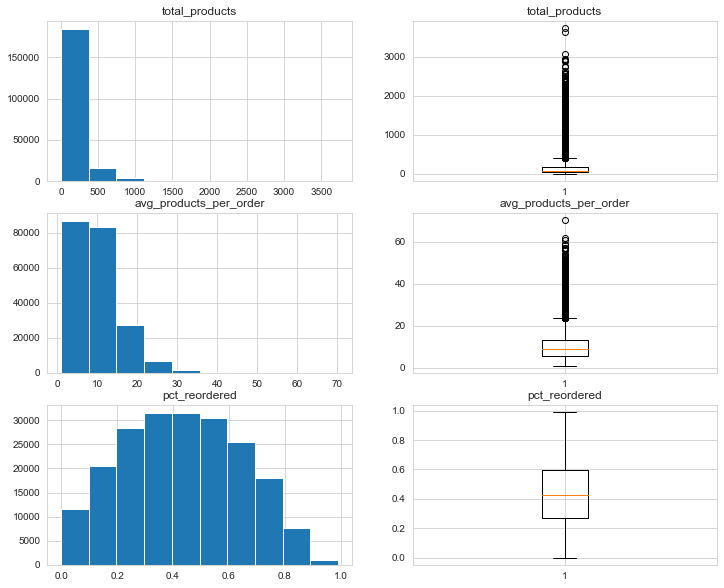

In [97]:
# products and reorders
prods = ['total_products','avg_products_per_order','pct_reordered']

x=0
plt.figure(figsize=(12,10))
for col in prods:
    plt.subplot(3,2,x+1)
    plt.hist(features_df[col])
    plt.title(col)
    plt.subplot(3,2,x+2)
    plt.boxplot(features_df[col])
    plt.title(col)
    x=x+2

In [98]:
features_df[prods].describe().round(2)

,total_products,avg_products_per_order,pct_reordered
count,206209.00,206209.00,206209.00
mean,157.29,9.95,0.43
std,204.21,5.86,0.21
min,3.00,1.00,0.00
25%,39.00,5.74,0.27
50%,83.00,8.93,0.43
75%,188.00,13.00,0.60
max,3725.00,70.25,0.99


**Observations:**
- Total products and average products per order skew right and have upper outliers. 
- Percent of reorded products appears to have a more normal distribution.

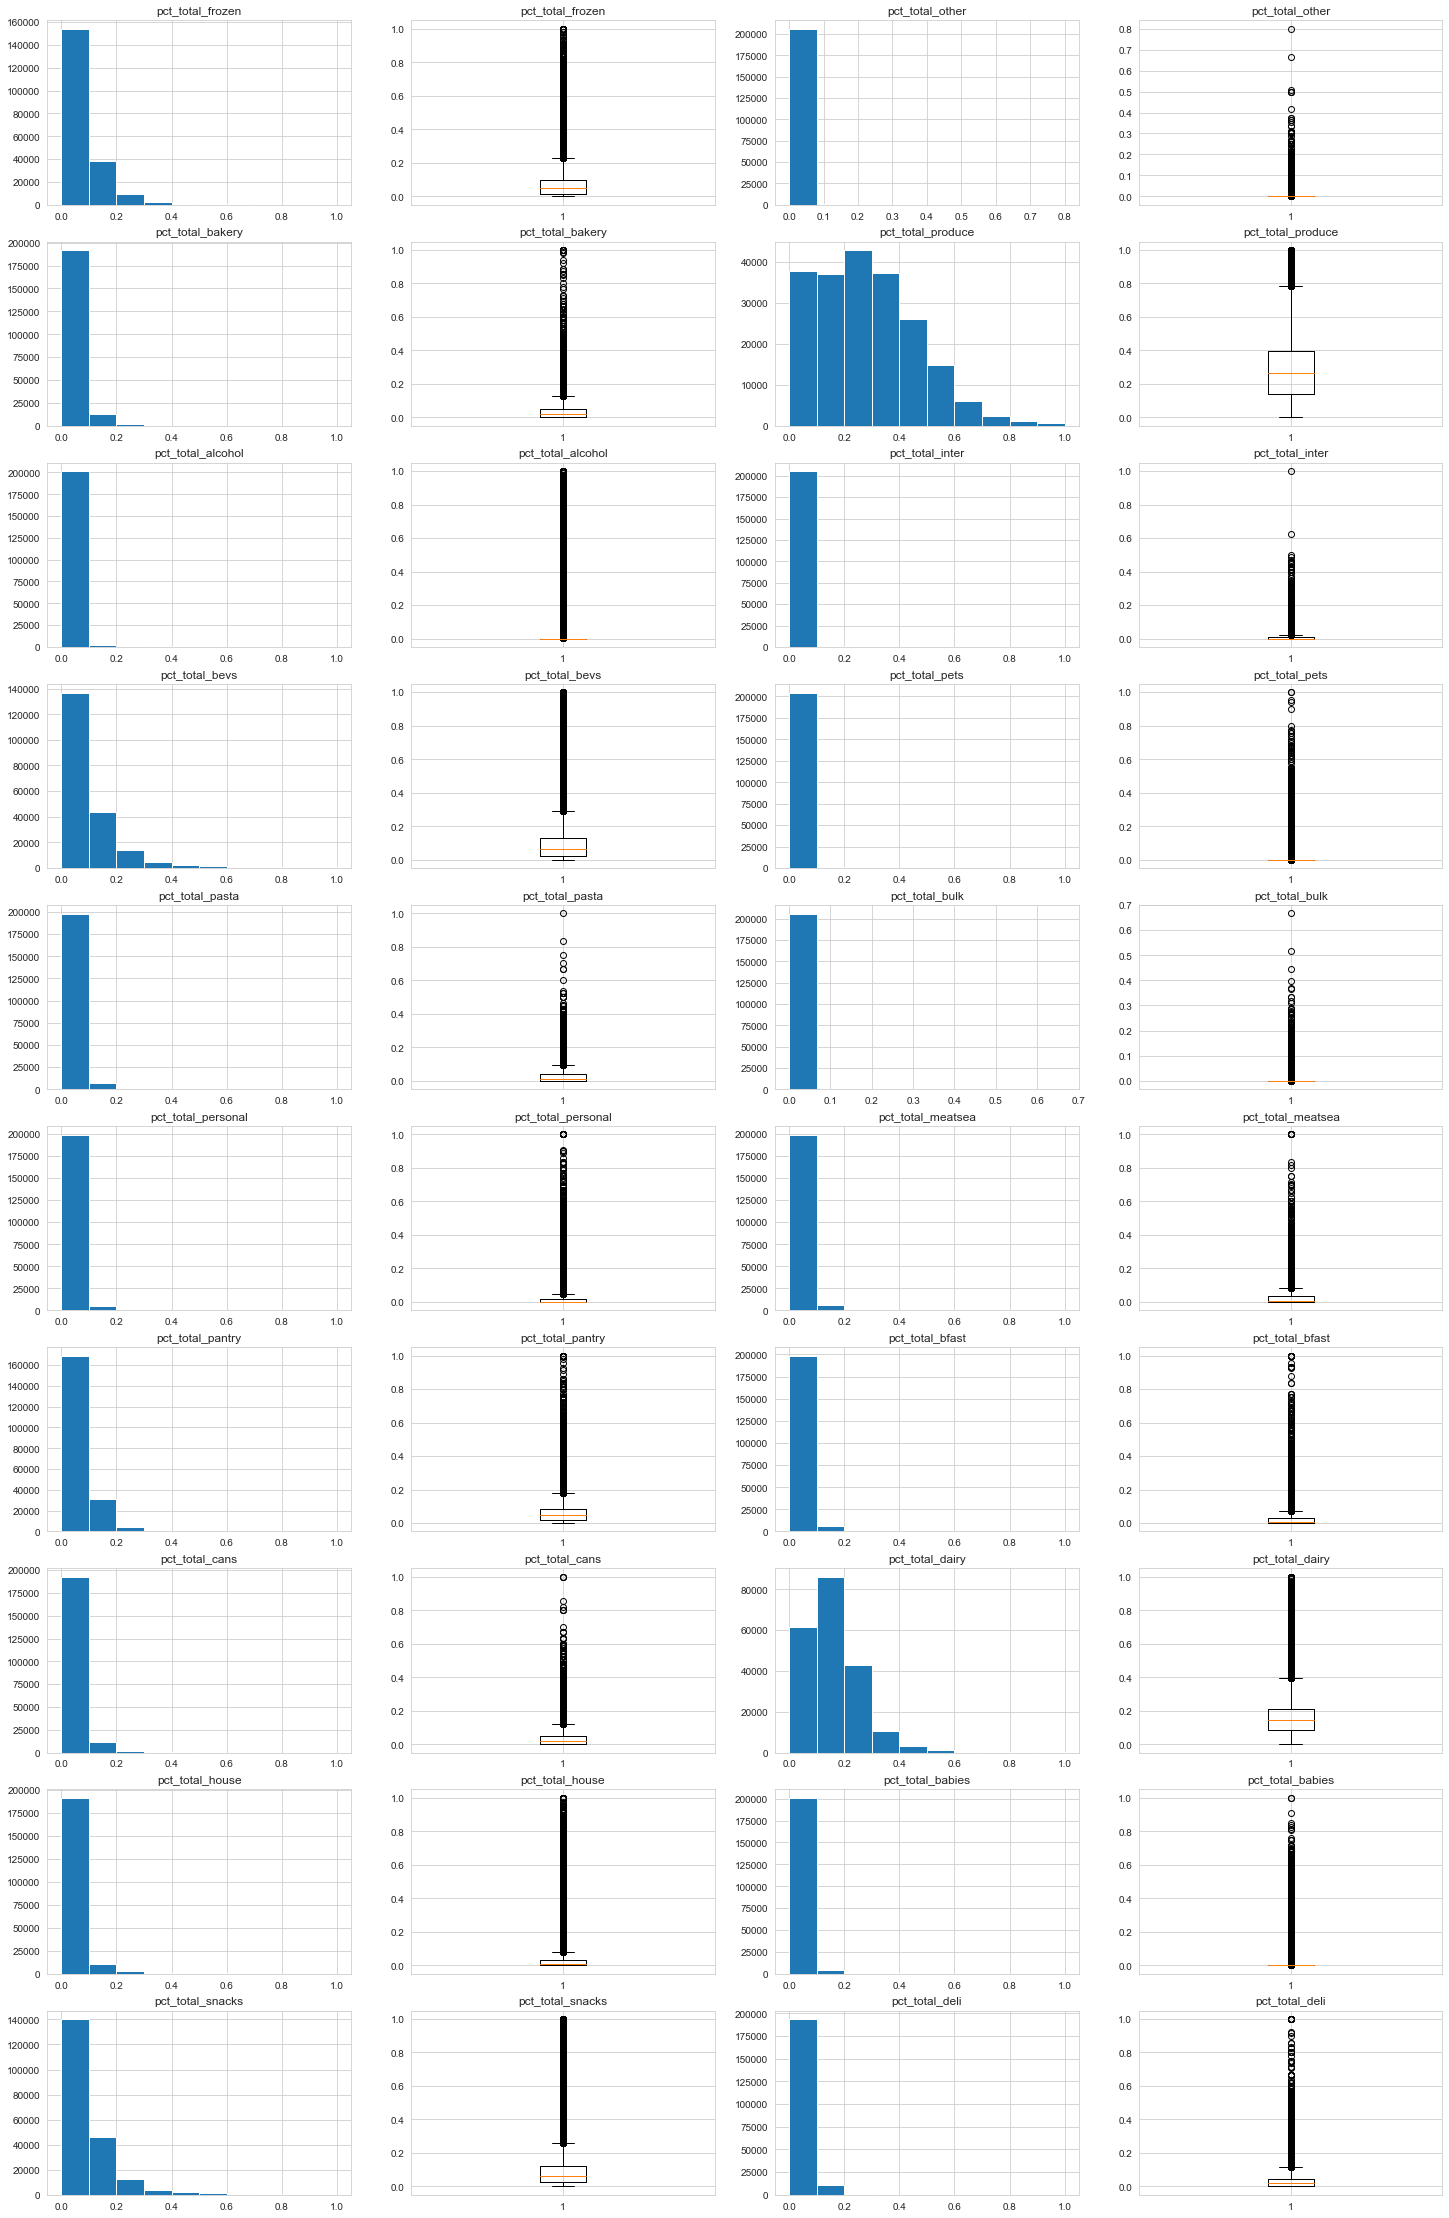

In [105]:
# departments
departments =  ['pct_total_frozen', 'pct_total_other', 'pct_total_bakery',
                'pct_total_produce', 'pct_total_alcohol', 'pct_total_inter',
                'pct_total_bevs', 'pct_total_pets', 'pct_total_pasta', 'pct_total_bulk',
                'pct_total_personal', 'pct_total_meatsea', 'pct_total_pantry',
                'pct_total_bfast', 'pct_total_cans', 'pct_total_dairy', 'pct_total_house',
                'pct_total_babies', 'pct_total_snacks', 'pct_total_deli']
x=0
plt.figure(figsize=(25,40))
for col in departments:
    plt.subplot(10,4,x+1)
    plt.hist(features_df[col])
    plt.title(col)
    plt.subplot(10,4,x+2)
    plt.boxplot(features_df[col])
    plt.title(col)
    x=x+2

In [106]:
features_df[departments].describe().round(2)

,pct_total_frozen,pct_total_other,pct_total_bakery,pct_total_produce,pct_total_alcohol,pct_total_inter,pct_total_bevs,pct_total_pets,pct_total_pasta,pct_total_bulk,pct_total_personal,pct_total_meatsea,pct_total_pantry,pct_total_bfast,pct_total_cans,pct_total_dairy,pct_total_house,pct_total_babies,pct_total_snacks,pct_total_deli
count,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00
mean,0.07,0.00,0.03,0.28,0.01,0.01,0.10,0.00,0.03,0.00,0.02,0.02,0.06,0.02,0.03,0.16,0.03,0.01,0.09,0.03
std,0.08,0.01,0.04,0.18,0.05,0.02,0.12,0.02,0.04,0.01,0.04,0.04,0.06,0.04,0.04,0.11,0.06,0.04,0.10,0.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.00,0.00,0.14,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.09,0.00,0.00,0.02,0.00
50%,0.05,0.00,0.02,0.27,0.00,0.00,0.06,0.00,0.01,0.00,0.00,0.01,0.05,0.01,0.02,0.15,0.01,0.00,0.06,0.02
75%,0.10,0.00,0.05,0.40,0.00,0.01,0.13,0.00,0.04,0.00,0.02,0.03,0.08,0.03,0.05,0.21,0.03,0.00,0.12,0.05
max,1.00,0.80,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.67,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


**Observations:**
- All variables skew right and have upper outliers. 
- Most averages are near 0, and most occurrences are below 10%
- Produce has the highest average at 28%, followed by dairy at 16%.

## Exploring correlations

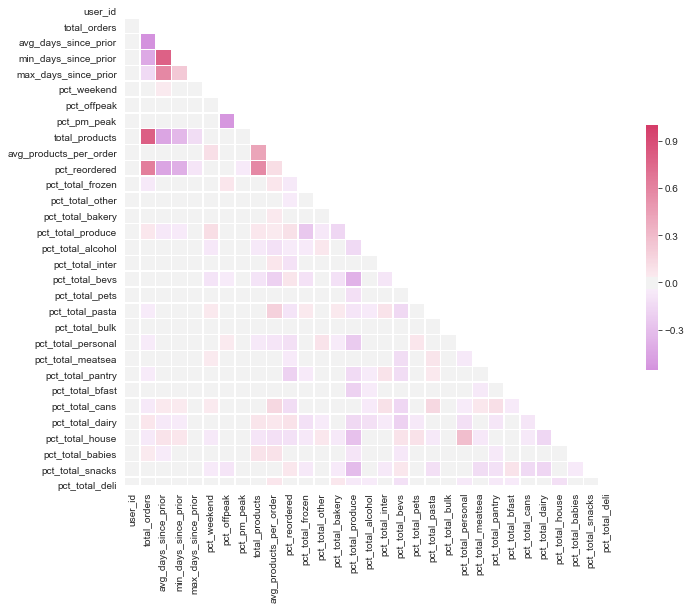

In [118]:
# heatmap
features_corr = features_df.corr()
mask = np.triu(np.ones_like(features_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(300, 0, as_cmap=True)
sns.heatmap(features_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [119]:
features_df.corr()

,user_id,total_orders,avg_days_since_prior,min_days_since_prior,max_days_since_prior,pct_weekend,pct_offpeak,pct_pm_peak,total_products,avg_products_per_order,...,pct_total_personal,pct_total_meatsea,pct_total_pantry,pct_total_bfast,pct_total_cans,pct_total_dairy,pct_total_house,pct_total_babies,pct_total_snacks,pct_total_deli
user_id,1.000000,-0.002122,0.003349,0.001782,0.002337,0.001683,0.000189,0.000223,-0.002171,-0.002283,...,-0.004266,0.001221,0.001156,0.000261,-0.002138,0.001873,-0.000511,-0.002446,-0.000287,-0.005087
total_orders,-0.002122,1.000000,-0.555102,-0.426398,-0.145993,-0.034856,-0.005014,-0.031878,0.807584,0.021919,...,-0.039689,-0.029370,-0.040820,-0.006688,-0.051777,0.069802,-0.054615,0.045167,0.013648,-0.010398
avg_days_since_prior,0.003349,-0.555102,1.000000,0.789493,0.585713,0.045733,-0.008304,0.034795,-0.451263,-0.023630,...,0.034653,0.023364,0.039471,0.015019,0.050350,-0.054047,0.084380,-0.043088,0.004375,0.006802
min_days_since_prior,0.001782,-0.426398,0.789493,1.000000,0.221260,0.039436,-0.009166,0.015781,-0.339323,0.001574,...,0.020725,0.015976,0.020525,0.023702,0.041323,-0.042250,0.065120,-0.036103,0.009322,0.002096
max_days_since_prior,0.002337,-0.145993,0.585713,0.221260,1.000000,0.032646,-0.003134,0.032945,-0.128118,-0.030853,...,0.015528,0.015855,0.025965,-0.005431,0.026947,-0.015589,0.038901,-0.011846,-0.009219,0.011328
pct_weekend,0.001683,-0.034856,0.045733,0.039436,0.032646,1.000000,-0.016723,0.023486,0.015787,0.106796,...,-0.032785,0.044734,-0.028202,-0.010988,0.045103,0.014752,-0.060265,-0.007747,-0.050186,0.026759
pct_offpeak,0.000189,-0.005014,-0.008304,-0.009166,-0.003134,-0.016723,1.000000,-0.522759,-0.003958,-0.003288,...,0.040652,0.000642,0.001334,0.003247,-0.003146,0.010793,0.015135,0.028110,-0.080825,0.005670
pct_pm_peak,0.000223,-0.031878,0.034795,0.015781,0.032945,0.023486,-0.522759,1.000000,-0.016525,0.026947,...,-0.015538,0.028155,0.011452,-0.019519,0.032157,-0.014745,-0.026295,-0.014514,-0.005510,0.013050
total_products,-0.002171,0.807584,-0.451263,-0.339323,-0.128118,0.015787,-0.003958,-0.016525,1.000000,0.424866,...,-0.060146,-0.008840,-0.036401,0.005258,0.012577,0.076106,-0.077793,0.085327,-0.000474,0.024865
avg_products_per_order,-0.002283,0.021919,-0.023630,0.001574,-0.030853,0.106796,-0.003288,0.026947,0.424866,1.000000,...,-0.082171,0.031790,0.001074,0.022642,0.145229,0.058470,-0.108570,0.090070,-0.035309,0.070494


In [120]:
pearsonr(features_df.total_products, features_df.total_orders)

(0.8075843293725893, 0.0)

In [121]:
pearsonr(features_df.total_products, features_df.pct_reordered)

(0.5716565164222078, 0.0)

In [122]:
pearsonr(features_df.avg_days_since_prior, features_df.max_days_since_prior)

(0.5857132678928023, 0.0)

In [123]:
pearsonr(features_df.avg_days_since_prior, features_df.min_days_since_prior)

(0.7894934263677834, 0.0)

In [124]:
pearsonr(features_df.pct_pm_peak, features_df.pct_offpeak)

(-0.5227593930746799, 0.0)

In [125]:
pearsonr(features_df.total_products, features_df.avg_days_since_prior)

(-0.4512626306823788, 0.0)

**Observations:**
- Total products is highly positively correlated with total orders and the percent of reordered products
- The percent of afternoon peak orders also has a negative correlation with percent of offpeak orders.

# Transforming and standardizing features for model

In [126]:
# removing variables with collinearity over +/- 0.5, with strong imbalances, and user id
model_df = features_df[['avg_days_since_prior', 'pct_weekend', 'pct_offpeak', 'total_products',
                        'avg_products_per_order', 'pct_total_frozen', 'pct_total_produce', 
                        'pct_total_bevs', 'pct_total_dairy']]

In [127]:
model_df.shape

(206209, 9)

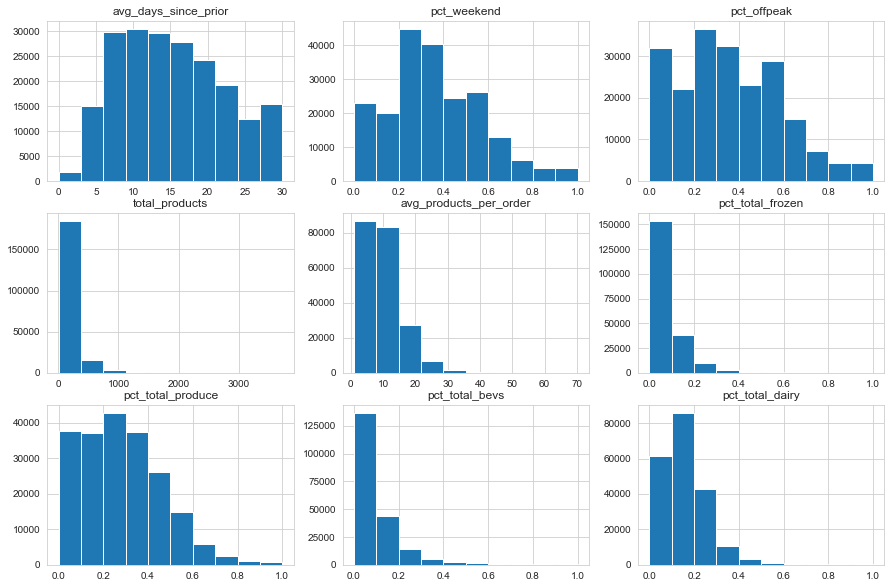

In [137]:
# visualizing distributions
x=1
plt.figure(figsize=(15,10))
for col in model_df:
    plt.subplot(3,3,x)
    plt.hist(model_df[col])
    plt.title(col)
    x=x+1

In [138]:
print(normaltest(model_df.avg_days_since_prior))
print(normaltest(model_df.pct_weekend))
print(normaltest(model_df.pct_offpeak))
print(normaltest(model_df.total_products))
print(normaltest(model_df.avg_products_per_order))
print(normaltest(model_df.pct_total_frozen))
print(normaltest(model_df.pct_total_produce))
print(normaltest(model_df.pct_total_bevs))
print(normaltest(model_df.pct_total_dairy))

NormaltestResult(statistic=16753.293318869128, pvalue=0.0)
NormaltestResult(statistic=9568.416281304373, pvalue=0.0)
NormaltestResult(statistic=6671.284191666341, pvalue=0.0)
NormaltestResult(statistic=142619.67827758496, pvalue=0.0)
NormaltestResult(statistic=45668.56705626255, pvalue=0.0)
NormaltestResult(statistic=125146.56225132596, pvalue=0.0)
NormaltestResult(statistic=10202.890463632792, pvalue=0.0)
NormaltestResult(statistic=136934.31209358608, pvalue=0.0)
NormaltestResult(statistic=70582.62890316344, pvalue=0.0)


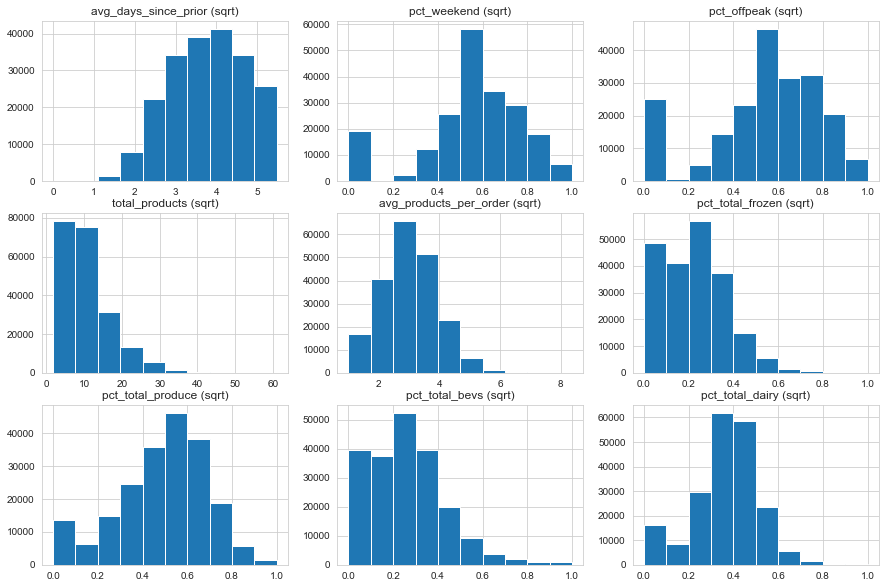

In [139]:
# visualizing square root transformations
x=1
plt.figure(figsize=(15,10))
for col in model_df:
    plt.subplot(3,3,x)
    plt.hist(np.sqrt(model_df[col]))
    plt.title(col+' (sqrt)')
    x=x+1

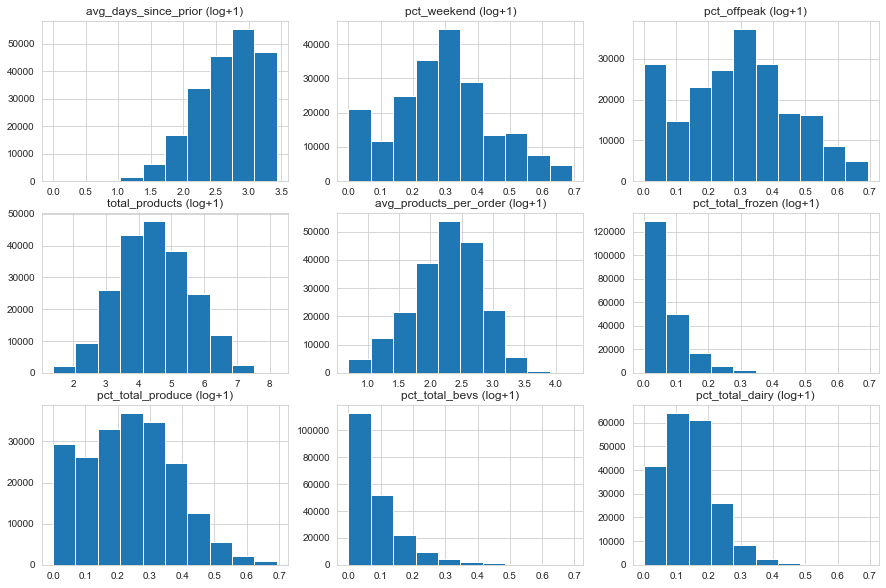

In [140]:
# visualizing log transformations
x=1
plt.figure(figsize=(15,10))
for col in model_df:
    plt.subplot(3,3,x)
    plt.hist(np.log(model_df[col]+1))
    plt.title(col+' (log+1)')
    x=x+1

In [128]:
# applying transformations that bring variables closer to normality
model_df.avg_days_since_prior = np.sqrt(model_df.avg_days_since_prior)
model_df.total_products = np.log(model_df.total_products)
model_df.avg_products_per_order = np.log(model_df.avg_products_per_order)
model_df.pct_weekend = np.sqrt(model_df.pct_weekend)
model_df.pct_offpeak = np.sqrt(model_df.pct_offpeak)
model_df.pct_total_frozen = np.sqrt(model_df.pct_total_frozen)
model_df.pct_total_produce = np.sqrt(model_df.pct_total_produce)
model_df.pct_total_bevs = np.sqrt(model_df.pct_total_bevs)
model_df.pct_total_dairy = np.sqrt(model_df.pct_total_dairy)

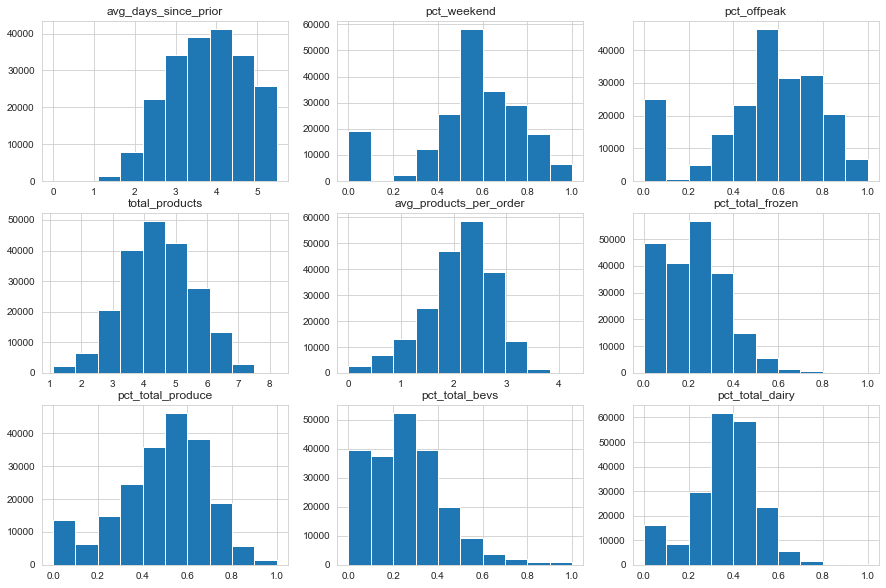

In [142]:
# visualizing distributions
x=1
plt.figure(figsize=(15,10))
for col in model_df:
    plt.subplot(3,3,x)
    plt.hist(model_df[col])
    plt.title(col)
    x=x+1

In [129]:
print(normaltest(model_df.avg_days_since_prior))
print(normaltest(model_df.pct_weekend))
print(normaltest(model_df.pct_offpeak))
print(normaltest(model_df.total_products))
print(normaltest(model_df.avg_products_per_order))
print(normaltest(model_df.pct_total_frozen))
print(normaltest(model_df.pct_total_produce))
print(normaltest(model_df.pct_total_bevs))
print(normaltest(model_df.pct_total_dairy))

NormaltestResult(statistic=10242.312376441674, pvalue=0.0)
NormaltestResult(statistic=23414.701594945855, pvalue=0.0)
NormaltestResult(statistic=15989.26014030584, pvalue=0.0)
NormaltestResult(statistic=1075.5870115408413, pvalue=2.749464018134745e-234)
NormaltestResult(statistic=10509.721186817898, pvalue=0.0)
NormaltestResult(statistic=3720.5640811990233, pvalue=0.0)
NormaltestResult(statistic=11006.769769172573, pvalue=0.0)
NormaltestResult(statistic=15929.127822050752, pvalue=0.0)
NormaltestResult(statistic=11702.867125087576, pvalue=0.0)


**Observations:**
- Variables skewed right and were not normal before transformation
- After transformations, variables are still not normally distributed, but the histograms above look closer to normal, with more points throughout the range.

# Sampling the dataset
My machine will be able to perform dimensionality reduction and modeling better with a sample.

In [130]:
# Sampling the data, so my machine can handle dimensionality reduction and modeling
model_sample = model_df.sample(frac=0.1, random_state=1)

In [131]:
model_sample.shape

(20621, 9)

In [146]:
model_sample.head()

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy
110191,3.605551,0.000000,0.577350,3.688879,2.590267,0.158114,0.651920,0.158114,0.387298
33115,4.289522,0.522233,0.426401,4.927254,2.529358,0.255377,0.659380,0.306925,0.208514
115997,2.841026,0.528271,0.340997,4.158883,0.397683,0.216506,0.176777,0.800391,0.176777
183156,3.405877,0.301511,0.000000,4.127134,1.729239,0.000000,0.567962,0.311086,0.538816
86975,2.323790,0.816497,0.707107,4.174387,2.382628,0.411377,0.526235,0.248069,0.248069


In [132]:
# Checking if any customers in the sample are the same
duplicateRowsDF = model_sample[model_sample.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [avg_days_since_prior, pct_weekend, pct_offpeak, total_products, avg_products_per_order, pct_total_frozen, pct_total_produce, pct_total_bevs, pct_total_dairy]
Index: []


In [133]:
type(model_sample)

pandas.core.frame.DataFrame

# Dimensionality reduction

In [134]:
# standardizing sample dataframe
scaler = StandardScaler()
model_std = scaler.fit_transform(model_sample)

In [135]:
type(model_std)

numpy.ndarray

In [136]:
columns_list = ['avg_days_since_prior', 'pct_weekend', 'pct_offpeak', 'total_products','avg_products_per_order',
                'pct_total_frozen', 'pct_total_produce', 'pct_total_bevs', 'pct_total_dairy']

In [137]:
# changing data type back to df
model_std = pd.DataFrame(model_std, columns=columns_list)
type(model_std)

pandas.core.frame.DataFrame

In [138]:
model_std.head()

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy
0,-0.186009,-2.384157,0.172281,-0.666742,0.733640,-0.394589,0.810783,-0.545963,0.149501
1,0.537834,-0.116365,-0.417089,0.426358,0.639372,0.236788,0.847118,0.295167,-1.015444
2,-0.995101,-0.090147,-0.750545,-0.251874,-2.659808,-0.015538,-1.503402,3.084403,-1.222245
3,-0.397322,-1.074847,-2.081947,-0.279899,-0.598968,-1.420974,0.401864,0.318684,1.136780
4,-1.542489,1.161472,0.678907,-0.238189,0.412278,1.249449,0.198633,-0.037504,-0.757706


## PCA

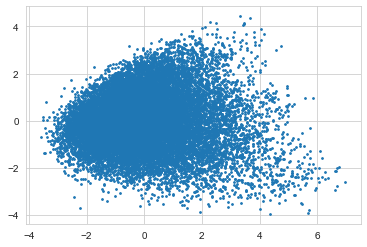

In [154]:
# PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(model_std)
plt.scatter(pca_components[ : , 0], pca_components[ : , 1], s =3);

In [155]:
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.24025238 0.15014963]


PCA does not return any discernable clusters in the above plot. Together, the first two components account for about 40% of variance.

## t-SNE

In [156]:
# perplexity 20
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(model_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20621 samples in 0.015s...
[t-SNE] Computed neighbors for 20621 samples in 7.888s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20621
[t-SNE] Computed conditional probabilities for sample 2000 / 20621
[t-SNE] Computed conditional probabilities for sample 3000 / 20621
[t-SNE] Computed conditional probabilities for sample 4000 / 20621
[t-SNE] Computed conditional probabilities for sample 5000 / 20621
[t-SNE] Computed conditional probabilities for sample 6000 / 20621
[t-SNE] Computed conditional probabilities for sample 7000 / 20621
[t-SNE] Computed conditional probabilities for sample 8000 / 20621
[t-SNE] Computed conditional probabilities for sample 9000 / 20621
[t-SNE] Computed conditional probabilities for sample 10000 / 20621
[t-SNE] Computed conditional probabilities for sample 11000 / 20621
[t-SNE] Computed conditional probabilities for sample 12000 / 20621
[t-SNE] Computed conditional probabilities for sam

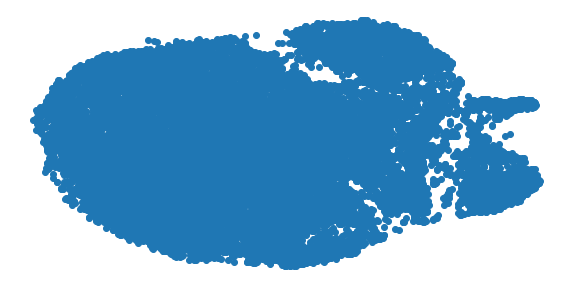

In [157]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [158]:
# perplexity 40
tsne2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results2 = tsne2.fit_transform(model_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20621 samples in 0.023s...
[t-SNE] Computed neighbors for 20621 samples in 7.911s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20621
[t-SNE] Computed conditional probabilities for sample 2000 / 20621
[t-SNE] Computed conditional probabilities for sample 3000 / 20621
[t-SNE] Computed conditional probabilities for sample 4000 / 20621
[t-SNE] Computed conditional probabilities for sample 5000 / 20621
[t-SNE] Computed conditional probabilities for sample 6000 / 20621
[t-SNE] Computed conditional probabilities for sample 7000 / 20621
[t-SNE] Computed conditional probabilities for sample 8000 / 20621
[t-SNE] Computed conditional probabilities for sample 9000 / 20621
[t-SNE] Computed conditional probabilities for sample 10000 / 20621
[t-SNE] Computed conditional probabilities for sample 11000 / 20621
[t-SNE] Computed conditional probabilities for sample 12000 / 20621
[t-SNE] Computed conditional probabilities for sa

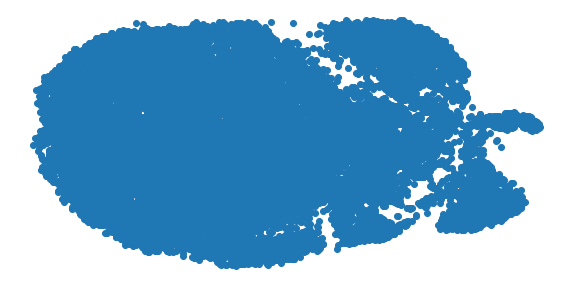

In [159]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results2[:, 0], tsne_results2[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The t-SNE plots indicate a large group of most customers, with some smaller clusters.

# Modeling

## K-means

In [154]:
# 3 clusters
labels0 = KMeans(n_clusters=3, random_state=123).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels0, metric='euclidean'))

0.1295932448981112


In [155]:
print(Counter(labels0))

Counter({1: 9445, 2: 7412, 0: 3764})


In [156]:
print('Percent of data in cluster 1: {}%'.format(round((9445/20621)*100)))
print('Percent of data in cluster 2: {}%'.format(round((7412/20621)*100)))
print('Percent of data in cluster 0: {}%'.format(round((3764/20621)*100)))

Percent of data in cluster 1: 46%
Percent of data in cluster 2: 36%
Percent of data in cluster 0: 18%


In [157]:
# 5 clusters
labels1 = KMeans(n_clusters=5, random_state=123).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels1, metric='euclidean'))

0.12003172928073992


In [158]:
print(Counter(labels1))

Counter({0: 6580, 3: 5665, 1: 4319, 4: 2263, 2: 1794})


In [159]:
print('Percent of data in cluster 0: {}%'.format(round((6580/20621)*100)))
print('Percent of data in cluster 3: {}%'.format(round((5665/20621)*100)))
print('Percent of data in cluster 1: {}%'.format(round((4319/20621)*100)))
print('Percent of data in cluster 4: {}%'.format(round((2263/20621)*100)))
print('Percent of data in cluster 2: {}%'.format(round((1794/20621)*100)))

Percent of data in cluster 0: 32%
Percent of data in cluster 3: 27%
Percent of data in cluster 1: 21%
Percent of data in cluster 4: 11%
Percent of data in cluster 2: 9%


In [160]:
# 2 clusters
labels2 = KMeans(n_clusters=2, random_state=123).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels2, metric='euclidean'))

0.19890567873433718


In [161]:
print(Counter(labels2))

Counter({1: 13812, 0: 6809})


In [162]:
print('Percent of data in cluster 1: {}%'.format(round((13812/20621)*100)))
print('Percent of data in cluster 0: {}%'.format(round((6809/20621)*100)))

Percent of data in cluster 1: 67%
Percent of data in cluster 0: 33%


**Results:** 
K-means with 2 clusters has the highest silhouette score at about 0.2. With this clustering, about 2/3 of customers are in the largest group. K-means with 3 clusters could also be useful for customer segmentation and marketing. The silhouette score for the 3 cluster model is 0.13, and the two largest groups include 46% and 36% percent of customers respectively.

## Hierarchical clustering

In [163]:
# 2 clusters, complete
labels3 = AgglomerativeClustering(linkage='complete', affinity='cosine', 
                                  n_clusters=2).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels3, metric='euclidean'))

0.03484693783966154


In [164]:
print(Counter(labels3))

Counter({0: 12096, 1: 8525})


In [165]:
print('Percent of data in cluster 0: {}%'.format(round((12096/20621)*100)))
print('Percent of data in cluster 1: {}%'.format(round((8525/20621)*100)))

Percent of data in cluster 0: 59%
Percent of data in cluster 1: 41%


In [166]:
# 2 clusters, ward
labels4 = AgglomerativeClustering(linkage='ward', affinity='euclidean', 
                                  n_clusters=2).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels4, metric='euclidean'))

0.05661934538701213


In [167]:
print(Counter(labels4))

Counter({0: 14006, 1: 6615})


In [168]:
print('Percent of data in cluster 0: {}%'.format(round((14006/20621)*100)))
print('Percent of data in cluster 1: {}%'.format(round((6615/20621)*100)))

Percent of data in cluster 0: 68%
Percent of data in cluster 1: 32%


In [169]:
# 2 clusters, average
labels5 = AgglomerativeClustering(linkage='average', affinity='cosine', 
                                  n_clusters=2).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels5, metric='euclidean'))

0.13400568659436374


In [170]:
print(Counter(labels5))

Counter({1: 11847, 0: 8774})


In [171]:
print('Percent of data in cluster 0: {}%'.format(round((8774/20621)*100)))
print('Percent of data in cluster 1: {}%'.format(round((11847/20621)*100)))

Percent of data in cluster 0: 43%
Percent of data in cluster 1: 57%


In [172]:
# 3 clusters, average
labels6 = AgglomerativeClustering(linkage='average', affinity='cosine', 
                                  n_clusters=3).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels6, metric='euclidean'))

0.1235301785968959


In [173]:
print(Counter(labels6))

Counter({0: 11847, 1: 6923, 2: 1851})


In [174]:
print('Percent of data in cluster 0: {}%'.format(round((11847/20621)*100)))
print('Percent of data in cluster 1: {}%'.format(round((6923/20621)*100)))
print('Percent of data in cluster 2: {}%'.format(round((1851/20621)*100)))

Percent of data in cluster 0: 57%
Percent of data in cluster 1: 34%
Percent of data in cluster 2: 9%


**Results:** Hierarchical clustering with 2 clusters and average linkage parameter has the highest silhouette score at about 0.13. In this model, about 57% of customers are in the largest group. 

## DBSCAN

In [175]:
# plotting nearest neighbors to find a good epsilon
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(model_std)
distances, indices = nbrs.kneighbors(model_std)

In [176]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

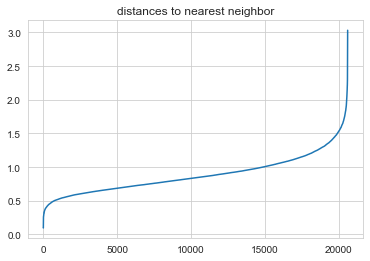

In [177]:
plt.plot(distances)
plt.title('distances to nearest neighbor');

In [178]:
# eps 1.5, min_sample 5
labels7 = DBSCAN(eps=1.5, min_samples=10).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels7, metric='euclidean'))

0.0678366212832824


In [179]:
print(Counter(labels7))

Counter({0: 18365, -1: 2074, 1: 31, 4: 24, 5: 24, 2: 23, 3: 19, 6: 11, 11: 10, 9: 10, 7: 10, 10: 7, 8: 7, 12: 6})


In [180]:
print('Percent of data in cluster 0: {}%'.format(round((18365/20621)*100)))
print('Percent of data in cluster 1: {}%'.format(round((31/20621)*100)))
print('Percent of noise: {}%'.format(round((2074/20621)*100)))

Percent of data in cluster 0: 89%
Percent of data in cluster 1: 0%
Percent of noise: 10%


In [181]:
# eps 1.5, min_sample 20
labels8 = DBSCAN(eps=1.5, min_samples=10).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels8, metric='euclidean'))

0.0678366212832824


In [182]:
print(Counter(labels8))

Counter({0: 18365, -1: 2074, 1: 31, 4: 24, 5: 24, 2: 23, 3: 19, 6: 11, 11: 10, 9: 10, 7: 10, 10: 7, 8: 7, 12: 6})


In [183]:
# eps 1.5, min_samples 3
labels9 = DBSCAN(eps=1.5, min_samples=3).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels9, metric='euclidean'))

-0.05774637755124329


In [184]:
print(Counter(labels9))

Counter({0: 19521, -1: 841, 8: 17, 36: 17, 11: 14, 28: 13, 24: 11, 4: 8, 2: 6, 12: 6, 16: 6, 22: 6, 32: 6, 46: 5, 15: 5, 19: 5, 23: 5, 47: 5, 54: 4, 1: 4, 18: 4, 14: 4, 17: 4, 25: 4, 26: 4, 30: 4, 41: 4, 42: 4, 3: 3, 44: 3, 5: 3, 6: 3, 7: 3, 9: 3, 10: 3, 34: 3, 27: 3, 13: 3, 20: 3, 21: 3, 49: 3, 29: 3, 31: 3, 33: 3, 35: 3, 43: 3, 52: 3, 50: 3, 38: 3, 37: 3, 39: 3, 48: 3, 40: 3, 53: 3, 51: 3, 45: 3})


In [185]:
# eps 1.3, min_samples 5
labels10 = DBSCAN(eps=1.3, min_samples=5).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels10, metric='euclidean'))

-0.07057510454138866


In [186]:
print(Counter(labels10))

Counter({0: 17015, -1: 2893, 2: 265, 1: 95, 4: 29, 11: 23, 20: 21, 5: 20, 7: 19, 13: 19, 6: 17, 14: 15, 3: 13, 12: 11, 25: 9, 10: 8, 9: 8, 19: 8, 30: 8, 22: 7, 24: 6, 17: 6, 15: 6, 41: 6, 23: 6, 32: 6, 35: 6, 37: 5, 8: 5, 26: 5, 29: 5, 36: 5, 27: 5, 18: 5, 31: 5, 21: 5, 42: 5, 40: 5, 39: 4, 38: 4, 28: 4, 16: 3, 33: 3, 34: 3})


In [187]:
print('Percent of data in cluster 0: {}%'.format(round((17015/20621)*100)))
print('Percent of data in cluster 2: {}%'.format(round((265/20621)*100)))
print('Percent of noise: {}%'.format(round((2893/20621)*100)))

Percent of data in cluster 0: 83%
Percent of data in cluster 2: 1%
Percent of noise: 14%


In [188]:
# eps 1.8, min_samples 5
labels11 = DBSCAN(eps=1.8, min_samples=5).fit_predict(model_std)
print(metrics.silhouette_score(model_std, labels11, metric='euclidean'))

0.22603128670896067


In [189]:
print(Counter(labels11))

Counter({0: 20282, -1: 309, 6: 6, 2: 6, 3: 5, 5: 5, 1: 4, 4: 4})


In [190]:
print('Percent of data in cluster 0: {}%'.format(round((20282/20621)*100)))
print('Percent of noise: {}%'.format(round((309/20621)*100)))

Percent of data in cluster 0: 98%
Percent of noise: 1%


**Results:**
DBSCAN is not a good model for this dataset. With all of the parameters I tried, most points are assigned to one cluster, and there is a substantial amount of noise. These models also identified some smaller clusters, but they are probably too small to be useful in a targeted marketing campaign. This is in line with the t-SNE plot above.

# Exploring clusters

## K-means with 2 clusters

In [191]:
# exploring km with 2 clusters
model_std['label_km2'] = labels2

In [192]:
# checking number of 0s
model_std[model_std['label_km2']==0]['label_km2'].count()

6809

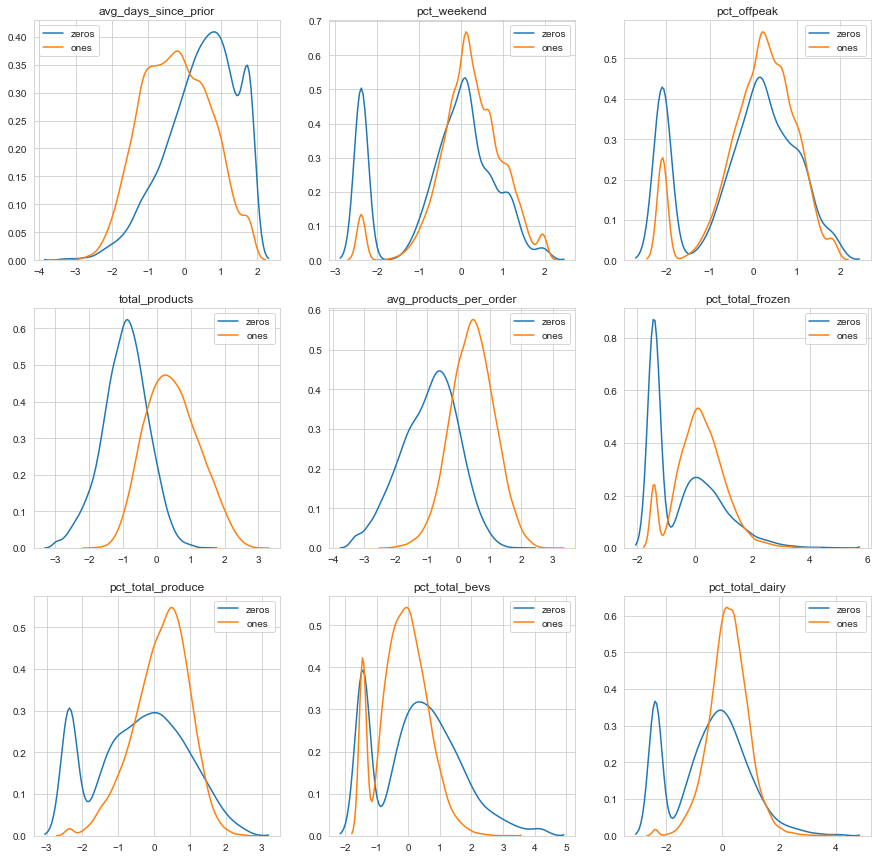

In [193]:
x=1
plt.figure(figsize=(15,15))
for col in model_std.drop(['label_km2'], axis=1).columns:
    plt.subplot(3,3,x)
    sns.kdeplot(model_std[model_std.label_km2 == 0][col], label='zeros')
    sns.kdeplot(model_std[model_std.label_km2 == 1][col], label='ones')
    plt.title(col)
    x=x+1

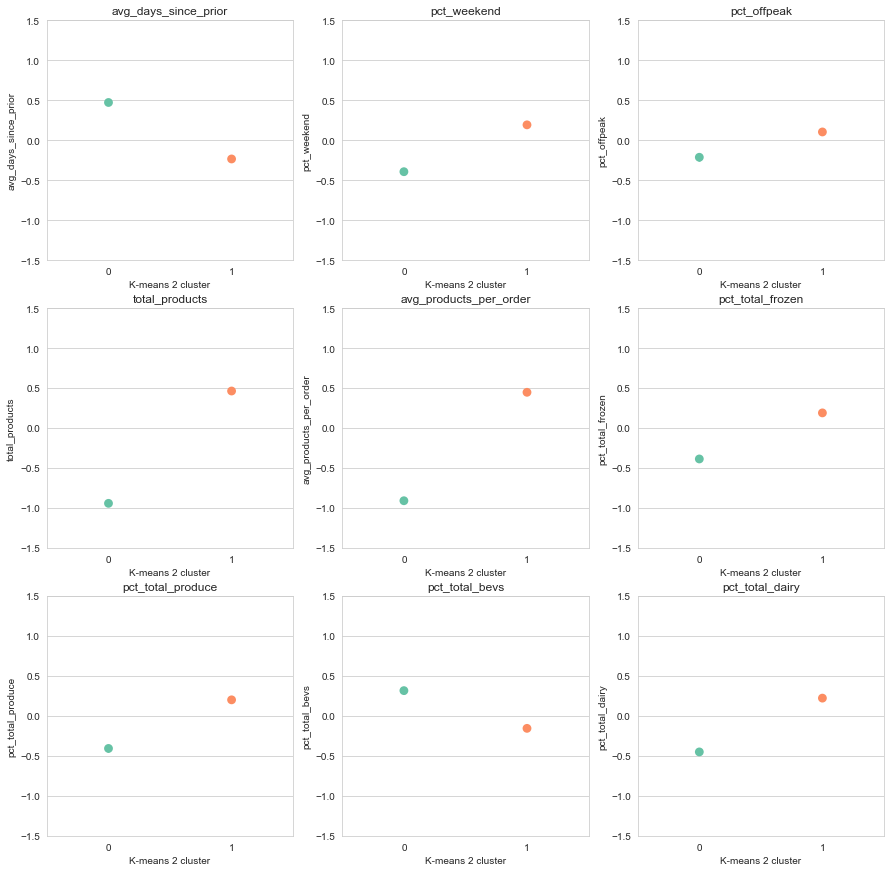

In [194]:
x=1
plt.figure(figsize=(15,15))
for col in model_std.drop(['label_km2'], axis=1).columns:
    plt.subplot(3,3,x)
    plt.ylim(-1.5, 1.5)
    sns.pointplot(x='label_km2', y=col, data=model_std, palette='Set2')
    plt.xlabel('K-means 2 cluster')
    plt.title(col)
    x=x+1

In [195]:
model_std[model_std['label_km2']==0].describe().round(2)

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy,label_km2
count,6809.00,6809.00,6809.00,6809.00,6809.00,6809.00,6809.00,6809.00,6809.00,6809.0
mean,0.47,-0.39,-0.21,-0.94,-0.91,-0.39,-0.41,0.32,-0.45,0.0
std,0.96,1.19,1.17,0.67,0.90,1.17,1.26,1.31,1.31,0.0
min,-3.33,-2.38,-2.08,-2.95,-3.28,-1.42,-2.36,-1.44,-2.37,0.0
25%,-0.12,-0.89,-0.85,-1.37,-1.54,-1.42,-1.30,-0.66,-1.32,0.0
50%,0.59,-0.14,0.06,-0.92,-0.83,-0.57,-0.32,0.33,-0.31,0.0
75%,1.20,0.36,0.68,-0.49,-0.26,0.43,0.55,1.17,0.42,0.0
max,1.79,1.96,1.82,1.42,1.96,5.07,2.51,4.21,4.14,0.0


In [196]:
model_std[model_std['label_km2']==1].describe().round(2)

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy,label_km2
count,13812.00,13812.00,13812.00,13812.00,13812.00,13812.00,13812.00,13812.00,13812.00,13812.0
mean,-0.23,0.19,0.10,0.46,0.45,0.19,0.20,-0.16,0.22,1.0
std,0.94,0.82,0.89,0.79,0.70,0.84,0.77,0.75,0.70,0.0
min,-3.14,-2.38,-2.08,-1.81,-2.19,-1.42,-2.36,-1.44,-2.37,1.0
25%,-0.96,-0.21,-0.34,-0.12,-0.02,-0.34,-0.28,-0.64,-0.20,1.0
50%,-0.25,0.20,0.17,0.41,0.46,0.17,0.28,-0.14,0.22,1.0
75%,0.47,0.69,0.68,1.01,0.92,0.70,0.74,0.35,0.65,1.0
max,1.79,1.96,1.82,2.93,3.04,3.98,2.51,3.22,4.02,1.0


**Observations:**
- Zeros tend to order less frequently and fewer products than Ones. They also tend to order smaller percentages of items in all of the departments I explored, except for beverages. 
- Among all departments, Ones order a higher percentage of dairy products on average.
- For this segementation, Instacart might push ads to Ones more frequently. They could also serve Zeros ads or discounts specifically for beverages; and Ones for dairy.

## K-means with 3 clusters

In [197]:
# exploring km with 3 clusters
model_std['label_km3'] = labels0

In [198]:
# checking number of 0s
model_std[model_std['label_km3']==0]['label_km3'].count()

3764

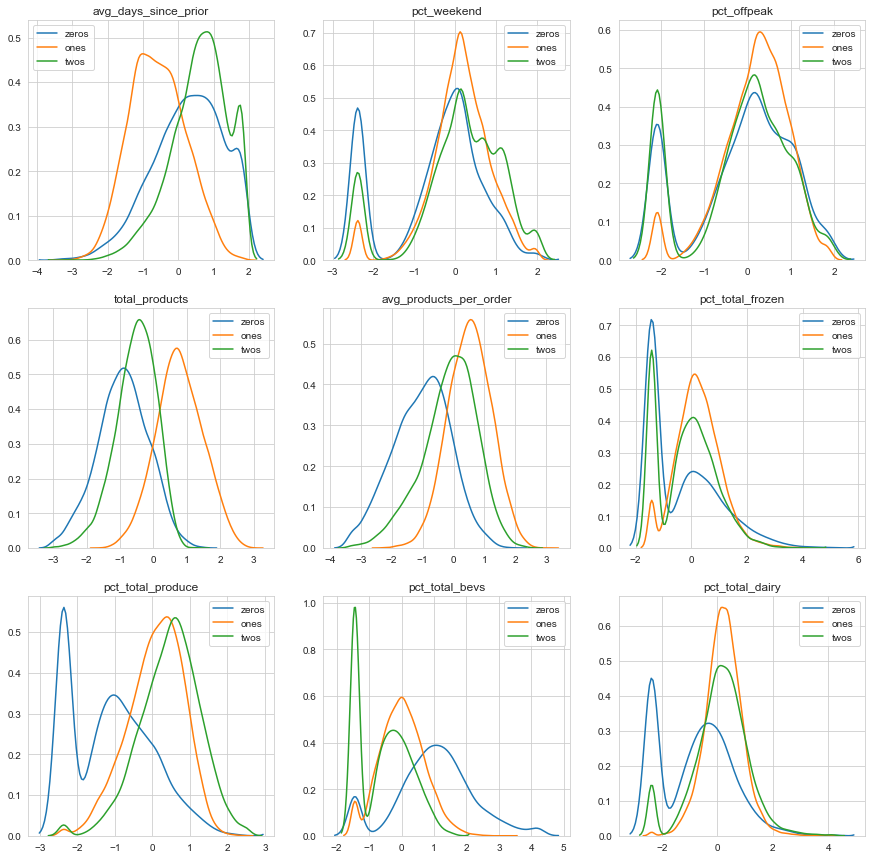

In [199]:
x=1
plt.figure(figsize=(15,15))
for col in model_std.drop(['label_km2', 'label_km3'], axis=1).columns:
    plt.subplot(3,3,x)
    sns.kdeplot(model_std[model_std.label_km3 == 0][col], label='zeros')
    sns.kdeplot(model_std[model_std.label_km3 == 1][col], label='ones')
    sns.kdeplot(model_std[model_std.label_km3 == 2][col], label='twos')
    plt.title(col)
    x=x+1

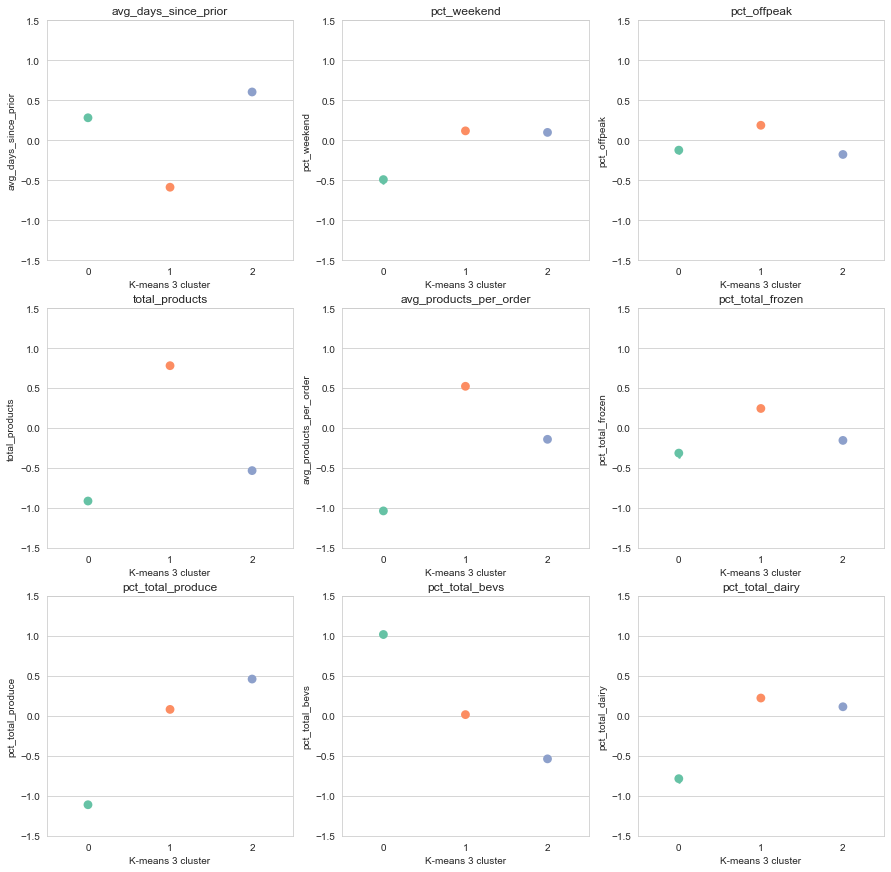

In [200]:
x=1
plt.figure(figsize=(15,15))
for col in model_std.drop(['label_km2', 'label_km3'], axis=1).columns:
    plt.subplot(3,3,x)
    plt.ylim(-1.5, 1.5)
    sns.pointplot(x='label_km3', y=col, data=model_std, palette='Set2')
    plt.xlabel('K-means 3 cluster')
    plt.title(col)
    x=x+1

In [201]:
model_std[model_std['label_km3']==0].describe().round(2)

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy,label_km2,label_km3
count,3764.00,3764.00,3764.00,3764.00,3764.00,3764.00,3764.00,3764.00,3764.00,3764.00,3764.0
mean,0.28,-0.49,-0.12,-0.91,-1.04,-0.31,-1.11,1.02,-0.79,0.03,0.0
std,0.99,1.16,1.14,0.77,0.93,1.27,1.06,1.21,1.27,0.17,0.0
min,-3.33,-2.38,-2.08,-2.95,-3.28,-1.42,-2.36,-1.44,-2.37,0.00,0.0
25%,-0.37,-1.01,-0.70,-1.42,-1.68,-1.42,-2.36,0.35,-2.37,0.00,0.0
50%,0.36,-0.21,0.17,-0.89,-0.98,-0.56,-1.12,1.05,-0.65,0.00,0.0
75%,1.02,0.23,0.68,-0.39,-0.38,0.55,-0.34,1.72,0.09,0.00,0.0
max,1.79,1.96,1.82,1.43,1.79,5.07,2.30,4.21,4.14,1.00,0.0


In [202]:
model_std[model_std['label_km3']==1].describe().round(2)

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy,label_km2,label_km3
count,9445.00,9445.00,9445.00,9445.00,9445.00,9445.00,9445.00,9445.00,9445.00,9445.00,9445.0
mean,-0.59,0.12,0.19,0.78,0.52,0.25,0.08,0.02,0.22,0.99,1.0
std,0.79,0.77,0.77,0.70,0.70,0.80,0.74,0.69,0.67,0.08,0.0
min,-3.25,-2.38,-2.08,-1.53,-2.27,-1.42,-2.36,-1.44,-2.37,0.00,1.0
25%,-1.16,-0.24,-0.24,0.31,0.05,-0.27,-0.39,-0.45,-0.18,1.00,1.0
50%,-0.62,0.12,0.27,0.76,0.53,0.21,0.15,0.00,0.22,1.00,1.0
75%,-0.04,0.58,0.68,1.26,1.01,0.73,0.62,0.46,0.63,1.00,1.0
max,1.79,1.96,1.82,2.93,3.04,3.85,2.30,3.22,4.02,1.00,1.0


In [203]:
model_std[model_std['label_km3']==2].describe().round(2)

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy,label_km2,label_km3
count,7412.00,7412.00,7412.00,7412.00,7412.00,7412.00,7412.00,7412.00,7412.00,7412.00,7412.0
mean,0.60,0.10,-0.18,-0.53,-0.14,-0.15,0.46,-0.54,0.11,0.58,2.0
std,0.80,1.09,1.13,0.61,0.90,1.00,0.81,0.78,1.00,0.49,0.0
min,-3.25,-2.38,-2.08,-2.95,-3.28,-1.42,-2.36,-1.44,-2.37,0.00,2.0
25%,0.11,-0.34,-0.70,-0.89,-0.67,-1.42,-0.04,-1.44,-0.40,0.00,2.0
50%,0.68,0.12,0.08,-0.49,-0.06,-0.11,0.52,-0.48,0.17,1.00,2.0
75%,1.18,0.85,0.68,-0.09,0.48,0.54,1.00,0.07,0.70,1.00,2.0
max,1.79,1.96,1.82,1.35,2.42,4.30,2.51,1.66,4.14,1.00,2.0


**Observations:**
- In a 3 cluster model, Ones tend to order more items and more frequently. There is also a higher distribution of Ones who order a greater percentage of frozen and dairy items. 
- Zeros order fewer products and less items in all departments, except for beverages. They are also least likely to order produce.
- Twos order least frequently and are least likely to order beverages. On average, they order the highest percentage of produce. 
- To implement this segmentation, Instacart could serve Ones adds more frequently and for frozen and dairy items. They could also promote beverages to Zeros and produce to Twos.

## Hierarchical with 2 clusters

In [204]:
# exploring hierarchical with 2 clusters
model_std['label_hier2'] = labels5

In [205]:
# checking number of 0s
model_std[model_std['label_hier2']==0]['label_hier2'].count()

8774

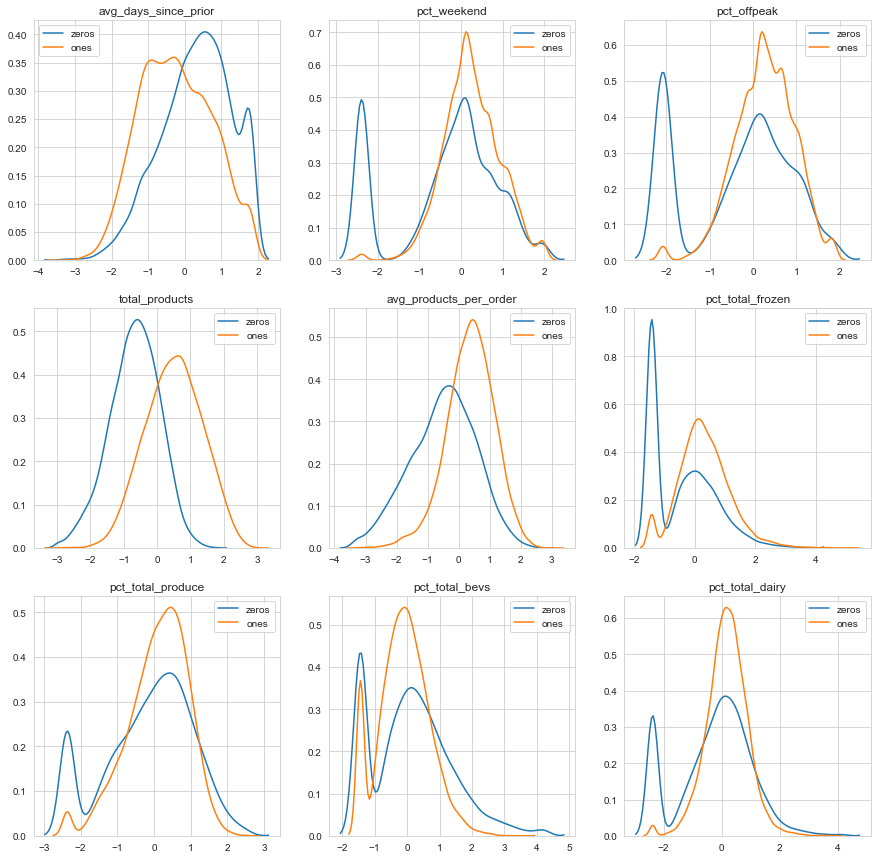

In [206]:
x=1
plt.figure(figsize=(15,15))
for col in model_std.drop(['label_km2', 'label_km3', 'label_hier2'], axis=1).columns:
    plt.subplot(3,3,x)
    sns.kdeplot(model_std[model_std.label_hier2 == 0][col], label='zeros')
    sns.kdeplot(model_std[model_std.label_hier2 == 1][col], label='ones')
    plt.title(col)
    x=x+1

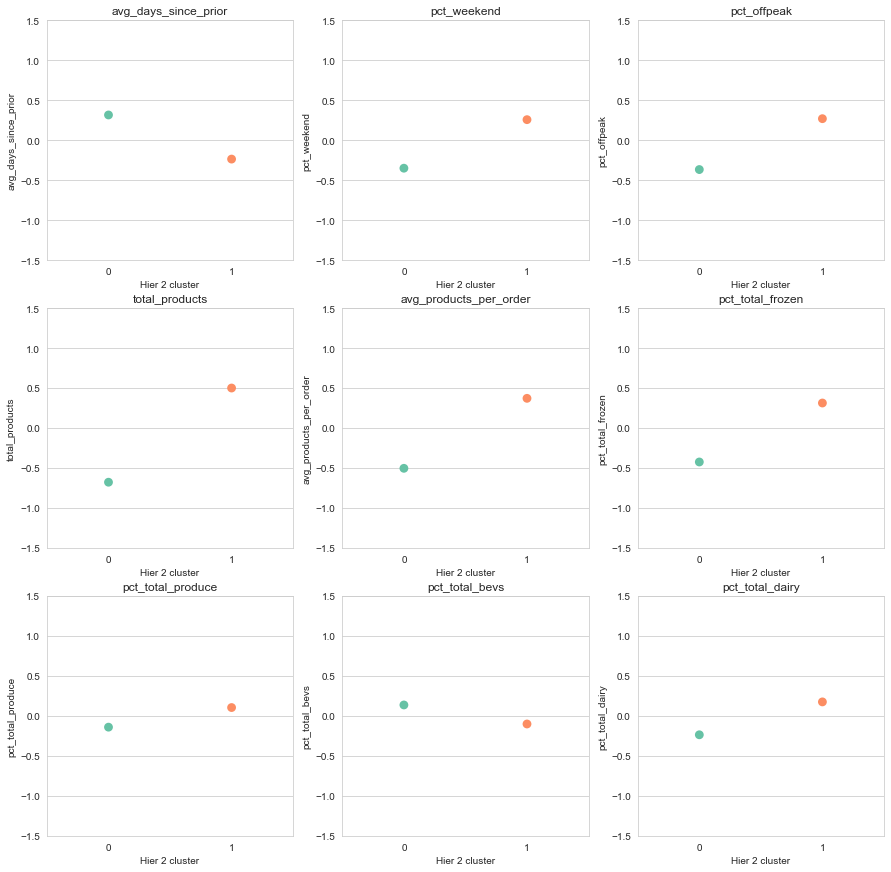

In [207]:
x=1
plt.figure(figsize=(15,15))
for col in model_std.drop(['label_km2', 'label_km3', 'label_hier2'], axis=1).columns:
    plt.subplot(3,3,x)
    plt.ylim(-1.5, 1.5)
    sns.pointplot(x='label_hier2', y=col, data=model_std, palette='Set2')
    plt.xlabel('Hier 2 cluster')
    plt.title(col)
    x=x+1

In [208]:
model_std[model_std['label_hier2']==0].describe().round(2)

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy,label_km2,label_km3,label_hier2
count,8774.00,8774.00,8774.00,8774.00,8774.00,8774.00,8774.00,8774.00,8774.00,8774.00,8774.00,8774.0
mean,0.32,-0.35,-0.37,-0.68,-0.50,-0.42,-0.14,0.14,-0.24,0.34,1.14,0.0
std,0.95,1.23,1.22,0.75,1.05,1.03,1.18,1.23,1.26,0.47,0.92,0.0
min,-3.33,-2.38,-2.08,-2.95,-3.28,-1.42,-2.36,-1.44,-2.37,0.00,0.00,0.0
25%,-0.32,-0.88,-2.08,-1.16,-1.22,-1.42,-0.90,-0.76,-0.94,0.00,0.00,0.0
50%,0.39,-0.06,-0.13,-0.64,-0.43,-0.47,0.04,0.10,-0.07,0.00,2.00,0.0
75%,1.02,0.46,0.59,-0.15,0.25,0.31,0.72,0.87,0.59,1.00,2.00,0.0
max,1.79,1.96,1.82,1.70,2.51,3.71,2.51,4.21,4.14,1.00,2.00,0.0


In [209]:
model_std[model_std['label_hier2']==1].describe().round(2)

,avg_days_since_prior,pct_weekend,pct_offpeak,total_products,avg_products_per_order,pct_total_frozen,pct_total_produce,pct_total_bevs,pct_total_dairy,label_km2,label_km3,label_hier2
count,11847.00,11847.00,11847.00,11847.00,11847.00,11847.00,11847.00,11847.00,11847.00,11847.00,11847.00,11847.0
mean,-0.23,0.26,0.27,0.50,0.37,0.31,0.10,-0.10,0.18,0.91,1.21,1.0
std,0.97,0.68,0.68,0.86,0.78,0.85,0.82,0.77,0.71,0.28,0.51,0.0
min,-3.25,-2.38,-2.08,-2.95,-3.28,-1.42,-2.36,-1.44,-2.37,0.00,0.00,1.0
25%,-0.99,-0.21,-0.13,-0.10,-0.10,-0.22,-0.38,-0.60,-0.24,1.00,1.00,1.0
50%,-0.28,0.21,0.29,0.52,0.41,0.26,0.20,-0.10,0.18,1.00,1.00,1.0
75%,0.50,0.69,0.71,1.11,0.90,0.81,0.69,0.40,0.61,1.00,2.00,1.0
max,1.79,1.96,1.82,2.93,3.04,5.07,2.47,3.58,3.82,1.00,2.00,1.0


**Observations:**
- In a 2 cluster hierarchical model, Ones order more items and more frequently.
- Like the K-means model with 2 clusters, Zeros order less of a share in all departments, except for beverages. In this model, Ones favor frozen items.
- Ones are also more likely to order over the weekend and during afternoon peak orders, while Zeros' ordering days/times are more variable.  
- To implement this segmentation, Instacart could push ads to Ones when they are most likely to order and continue to push ads to Zeros at anytime. They could promote beverages to Zeros and frozen items to Ones.

# Conclusions
After assessing K-Means, Hierarchical, and DBSCAN models, I would recommend that Instacart uses a K-means model with 2 clusters to design a targeted marketing campaign. This model has the highest silhouette score of all models I tested, and it will allow the company to address two groups of customers in a more personalized way. About 2/3 of customers will get one message and 1/3 of customers will get another based on their purchase history.

Based on this segmentation, Instacart could experiment with pushing ads to Ones for dairy products, while promoting beverages to Zeros. In all of the clusters I explored, there was an interesting trend where one group of customers ordered less frequently and favored beverages (note this is separate from alcohol). It would useful to learn more about this group to see if there is an opportunity to sell a greater variety of products to them. 

The customer segmentation I suggest could also be improved with additional datapoints. For example, it would be useful to collect and consider:
- Recency, time between a customer's last order and the marketing send
- Cost, typical price of products and total order
- Location, zip code where a customer lives and shops